# Análisis de la Tienda de Fortnite: Emotes y Bailes

Este análisis explora los datos de la tienda de Fortnite, enfocándose específicamente en los emotes (bailes) disponibles en el juego. Se analizan patrones de popularidad, características y relaciones entre diferentes emotes.

##### Setup inicial

In [292]:
!pip install scikit-learn
!pip install opencv-python pillow tensorflow requests
!pip install moviepy
# Instalar PyTorch
!pip install torch torchvision torchaudio

# Instalar otras dependencias
!pip install transformers tensorflow opencv-python scikit-learn plotly pandas numpy tqdm

In [293]:
# Import de librerías
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import json

In [294]:
# Configuración para mostrar todas las columnas
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)     

In [295]:
# Archivos de entrada
file_input_emotes = "items_en.json" #-> Origen API de Fortnite
file_input_votes = "votes_data.csv" #-> Origen scraping de FortniteGG (es una página de datos de fortnite -la más popular-)
file_input_sounds = "emotes_sounds_features.csv" #-> Este archivo contiene el resultado descargar los videos, 
                                                 # extraer el audio de los videos, extraer las caracteristicas de los audios, además de
                                                 # conectar a la API para reconocer el artista, nombre de la canción  y otros datos... 
                                                 # pensé en incluirlo los archivos que hacen esto, pero creo que sale del alcance de esta práctica...


# Archivo intermedio con items filtrados por tipo "Gesto/Emote"
file_output = "emotes.csv"

#### Cargar datos

In [296]:
# Cargar archivo json con información de items cosmeticos de la tienda de Fortnite

# 1. Cargar el JSON
with open(file_input_emotes, 'r', encoding='utf-8') as file:
    data = json.load(file)

# 2. Crear el DataFrame directamente de la lista de items
df_items = pd.json_normalize(
    data['items'],  
    sep='_',
    max_level=100
)
# Aplico la normalización para que los datos queden en un dataframe, después habrá que filtrar las columnas que sean necesarias

In [297]:
# Cargar el csv con los datos de popularidad de los emotes origen -> FortniteGG

df_votes = pd.read_csv(file_input_votes, sep=';')


In [298]:
# Cargar archivo con las caracteristicas de los audios
df_sounds = pd.read_csv(file_input_sounds, sep=';')

In [299]:
df_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18638 entries, 0 to 18637
Data columns (total 61 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    18638 non-null  object 
 1   name                                  18638 non-null  object 
 2   description                           18638 non-null  object 
 3   series                                0 non-null      float64
 4   price                                 18638 non-null  int64  
 5   builtInEmote                          0 non-null      float64
 6   copyrightedAudio                      18638 non-null  bool   
 7   upcoming                              18638 non-null  bool   
 8   reactive                              18638 non-null  bool   
 9   releaseDate                           5757 non-null   object 
 10  lastAppearance                        5757 non-null   object 
 11  interest       

In [300]:
df_items.head()

,id,name,description,series,price,builtInEmote,copyrightedAudio,upcoming,reactive,releaseDate,lastAppearance,interest,video,audio,path,gameplayTags,apiTags,battlepass,type_id,type_name,rarity_id,rarity_name,added_date,added_version,images_icon,images_featured,images_background,images_icon_background,images_full_background,juno_icon,beans_icon,set_id,set_name,set_partOf,battlepass_season,battlepass_tier,battlepass_page,battlepass_type,battlepass_displayText_chapter,battlepass_displayText_season,battlepass_displayText_chapterSeason,battlepass_battlePassName,set,series_id,series_name,builtInEmote_id,builtInEmote_type_id,builtInEmote_type_name,builtInEmote_name,builtInEmote_description,builtInEmote_rarity_id,builtInEmote_rarity_name,builtInEmote_series,builtInEmote_images_icon,builtInEmote_images_featured,builtInEmote_images_background,builtInEmote_images_icon_background,builtInEmote_images_full_background,builtInEmote_video,builtInEmote_series_id,builtInEmote_series_name
0,CID_267_Athena_Commando_M_RobotRed,A.I.M.,Scanning area for targets...,NaN,0,NaN,False,False,False,None,None,0.00,None,None,/Game/Athena/Items/Cosmetics/Characters/CID_26...,"[Cosmetics.Source.Season6.BattlePass.Paid, Cos...",[],NaN,outfit,Outfit,Legendary,LEGENDARY,2018-09-27,6.0,https://media.fortniteapi.io/images/552cd39-33...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/icons/juno...,https://media.fortniteapi.io/images/icons/bean...,RobotRed,A.I.M.,Part of the A.I.M. set.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,CID_249_Athena_Commando_F_BlackWidow,Arachne,Weave a web to victory.,NaN,2000,NaN,False,False,False,2018-10-21,2024-08-11,0.00,None,None,/BRCosmetics/Athena/Items/Cosmetics/Characters...,"[Cosmetics.Source.ItemShop, Cosmetics.Set.Blac...",[],NaN,outfit,Outfit,Legendary,LEGENDARY,2018-09-27,6.0,https://media.fortniteapi.io/images/c0884dc-59...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/icons/juno...,https://media.fortniteapi.io/images/icons/bean...,BlackWidow,Arachnid,Part of the Arachnid set.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,CID_300_Athena_Commando_F_Angel,Ark,Upholding the principles of righteous victory.,NaN,2000,NaN,False,False,False,2019-01-11,2024-10-21,0.00,None,None,/BRCosmetics/Athena/Items/Cosmetics/Characters...,"[Cosmetics.Source.ItemShop, Cosmetics.Set.Eter...",[],NaN,outfit,Outfit,Legendary,LEGENDARY,2018-12-06,7.00,https://media.fortniteapi.io/images/f3b50ea-ab...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/icons/juno...,https://media.fortniteapi.io/images/icons/bean...,EternalStruggle,Eternal Struggle,Part of the Eternal Struggle set.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,CID_100_Athena_Commando_M_CuChulainn,Battle Hound,Release the hound!,NaN,2000,NaN,False,False,False,2018-03-18,2024-09-17,0.00,None,None,/BRCosmetics/Athena/Items/Cosmetics/Characters...,"[Cosmetics.Source.ItemShop, Cosmetics.Set.Laoc...",[],NaN,outfit,Outfit,Legendary,LEGENDARY,2018-02-22,3.0.0,https://media.fortniteapi.io/images/7e44eaf-73...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/icons/juno...,https://media.fortniteapi.io/images/icons/bean...,Laoch,Laoch,Part of the Laoch set.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

#### Filtrar por tipo de item: Gesto - Emote

In [301]:
# Filtrar por tipo de item: Gesto - Emote

df_emotes = df_items[
    df_items["type_name"] == "Emote"]

df_emotes.info()


<class 'pandas.core.frame.DataFrame'>
Index: 1279 entries, 257 to 18625
Data columns (total 61 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    1279 non-null   object 
 1   name                                  1279 non-null   object 
 2   description                           1279 non-null   object 
 3   series                                0 non-null      float64
 4   price                                 1279 non-null   int64  
 5   builtInEmote                          0 non-null      float64
 6   copyrightedAudio                      1279 non-null   bool   
 7   upcoming                              1279 non-null   bool   
 8   reactive                              1279 non-null   bool   
 9   releaseDate                           653 non-null    object 
 10  lastAppearance                        653 non-null    object 
 11  interest           

#### Mergear los datos de popularidad con los datos de los emotes


In [302]:
df_votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             1056 non-null   int64 
 1   name           1056 non-null   object
 2   url            1056 non-null   object
 3   wishlists      1056 non-null   object
 4   occurrences    1056 non-null   int64 
 5   votes_fire     1055 non-null   object
 6   votes_love     1055 non-null   object
 7   votes_neutral  1055 non-null   object
 8   votes_disgust  1055 non-null   object
 9   votes_poop     1055 non-null   object
dtypes: int64(2), object(8)
memory usage: 82.6+ KB


In [303]:
#Borrar las columnas id, url
df_votes = df_votes.drop(columns=["id", "url"])
df_votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name           1056 non-null   object
 1   wishlists      1056 non-null   object
 2   occurrences    1056 non-null   int64 
 3   votes_fire     1055 non-null   object
 4   votes_love     1055 non-null   object
 5   votes_neutral  1055 non-null   object
 6   votes_disgust  1055 non-null   object
 7   votes_poop     1055 non-null   object
dtypes: int64(1), object(7)
memory usage: 66.1+ KB


In [304]:
df_votes.head()

,name,wishlists,occurrences,votes_fire,votes_love,votes_neutral,votes_disgust,votes_poop
0,NUTHIN BUT A G THANG,483,1,1.5K,99,147,42,381
1,BIG SPIN,169,4,472,131,408,254,3.5K
2,COFFIN,"1,128",3,3.1K,307,763,290,3.5K
3,OH SHHH,"1,202",7,4.6K,680,881,463,7.5K
4,IN HA MOOD,"1,536",7,5.8K,801,1K,505,7K


In [305]:
# Format columns votes to int64
def convert_k_to_number(value):
    if pd.isna(value):
        return 0
    value = str(value).strip()
    if value.endswith('K'):
        # Convertir "8.2K" a 8200
        return int(float(value[:-1]) * 1000)
    else:
        # Convertir string normal a int
        return int(value)

# Convertir todas las columnas de votos
vote_columns = [
    'votes_fire', 
    'votes_love', 
    'votes_neutral',
    'votes_disgust', 
    'votes_poop',
]

for col in vote_columns:
    df_votes[col] = df_votes[col].apply(convert_k_to_number)

# Verificar la conversión
print("Primeras filas después de la conversión:")
print(df_votes[['name'] + vote_columns].head())

# Verificar tipos de datos
print("\nTipos de datos:")
print(df_votes[vote_columns].dtypes)

# Estadísticas básicas de los votos
print("\nEstadísticas de votos:")
print(df_votes[vote_columns].describe())


Primeras filas después de la conversión:
                   name  votes_fire  votes_love  votes_neutral  votes_disgust  \
0  NUTHIN BUT A G THANG        1500          99            147             42   
1              BIG SPIN         472         131            408            254   
2                COFFIN        3100         307            763            290   
3               OH SHHH        4600         680            881            463   
4            IN HA MOOD        5800         801           1000            505   

   votes_poop  
0         381  
1        3500  
2        3500  
3        7500  
4        7000  

Tipos de datos:
votes_fire       int64
votes_love       int64
votes_neutral    int64
votes_disgust    int64
votes_poop       int64
dtype: object

Estadísticas de votos:
         votes_fire   votes_love  votes_neutral  votes_disgust    votes_poop
count   1056.000000  1056.000000    1056.000000    1056.000000   1056.000000
mean    4259.569129   622.523674     696.498106     

In [306]:
df_votes.head()

,name,wishlists,occurrences,votes_fire,votes_love,votes_neutral,votes_disgust,votes_poop
0,NUTHIN BUT A G THANG,483,1,1500,99,147,42,381
1,BIG SPIN,169,4,472,131,408,254,3500
2,COFFIN,"1,128",3,3100,307,763,290,3500
3,OH SHHH,"1,202",7,4600,680,881,463,7500
4,IN HA MOOD,"1,536",7,5800,801,1000,505,7000


In [307]:
# Convert wishlists and occurrences to int64
df_votes['wishlists'] = df_votes['wishlists'].str.replace(',', '').astype('int64')
df_votes['occurrences'] = df_votes['occurrences'].astype('int64')

# Verify the conversion
print("\nTipos de datos:")
print(df_votes[['wishlists', 'occurrences']].dtypes)


Tipos de datos:
wishlists      int64
occurrences    int64
dtype: object


In [308]:
#rename columns name to name_upper
df_votes.rename(columns={"name": "name_upper"}, inplace=True)
df_votes.head()

,name_upper,wishlists,occurrences,votes_fire,votes_love,votes_neutral,votes_disgust,votes_poop
0,NUTHIN BUT A G THANG,483,1,1500,99,147,42,381
1,BIG SPIN,169,4,472,131,408,254,3500
2,COFFIN,1128,3,3100,307,763,290,3500
3,OH SHHH,1202,7,4600,680,881,463,7500
4,IN HA MOOD,1536,7,5800,801,1000,505,7000


In [309]:
# column name_upper
df_emotes["name_upper"] = df_emotes["name"].str.upper()
df_emotes.head(2)

/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_17152/887619300.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emotes["name_upper"] = df_emotes["name"].str.upper()


,id,name,description,series,price,builtInEmote,copyrightedAudio,upcoming,reactive,releaseDate,lastAppearance,interest,video,audio,path,gameplayTags,apiTags,battlepass,type_id,type_name,rarity_id,rarity_name,added_date,added_version,images_icon,images_featured,images_background,images_icon_background,images_full_background,juno_icon,beans_icon,set_id,set_name,set_partOf,battlepass_season,battlepass_tier,battlepass_page,battlepass_type,battlepass_displayText_chapter,battlepass_displayText_season,battlepass_displayText_chapterSeason,battlepass_battlePassName,set,series_id,series_name,builtInEmote_id,builtInEmote_type_id,builtInEmote_type_name,builtInEmote_name,builtInEmote_description,builtInEmote_rarity_id,builtInEmote_rarity_name,builtInEmote_series,builtInEmote_images_icon,builtInEmote_images_featured,builtInEmote_images_background,builtInEmote_images_icon_background,builtInEmote_images_full_background,builtInEmote_video,builtInEmote_series_id,builtInEmote_series_name,name_upper
257,EID_BoogieDown,Boogie Down,Boogie Down with Populotus.,NaN,0,NaN,False,False,False,None,None,3.07,https://media.fortniteapi.io/videos/cosmetics/...,None,/BRCosmetics/Athena/Items/Cosmetics/Dances/EID...,"[Cosmetics.EmoteType.Dance, Cosmetics.Filter.S...","[emoteDuration:4.40, emoteLoop]",NaN,emote,Emote,Epic,Epic,2018-05-01,4.0,None,None,None,None,None,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BOOGIE DOWN
258,EID_HipHopS5,Breakdown,Break it down.,NaN,0,NaN,False,False,False,None,None,0.04,https://media.fortniteapi.io/videos/cosmetics/...,None,/BRCosmetics/Athena/Items/Cosmetics/Dances/EID...,"[Cosmetics.EmoteType.Dance, Cosmetics.Source.S...","[emoteDuration:7.27, emoteLoop]",NaN,emote,Emote,Epic,Epic,2018-07-11,4.5-CU,https://media.fortniteapi.io/images/d9e9d59-b0...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None,None,NaN,NaN,NaN,5.0,95.0,NaN,paid,Chapter 1,Season 5,Chapter 1 - Season 5,Battle Pass,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BREAKDOWN


In [310]:
#Después que realicé el scraping me di cuenta de que debí traerme el id en vez del nombre... ahora tendré que hacer un poco de salvajadas... perdon...

#buscar elementos duplicados en df_emotes por name_upper
df_emotes[df_emotes.duplicated(subset=['name_upper'], keep=False)].sort_values('name_upper')

,id,name,description,series,price,builtInEmote,copyrightedAudio,upcoming,reactive,releaseDate,lastAppearance,interest,video,audio,path,gameplayTags,apiTags,battlepass,type_id,type_name,rarity_id,rarity_name,added_date,added_version,images_icon,images_featured,images_background,images_icon_background,images_full_background,juno_icon,beans_icon,set_id,set_name,set_partOf,battlepass_season,battlepass_tier,battlepass_page,battlepass_type,battlepass_displayText_chapter,battlepass_displayText_season,battlepass_displayText_chapterSeason,battlepass_battlePassName,set,series_id,series_name,builtInEmote_id,builtInEmote_type_id,builtInEmote_type_name,builtInEmote_name,builtInEmote_description,builtInEmote_rarity_id,builtInEmote_rarity_name,builtInEmote_series,builtInEmote_images_icon,builtInEmote_images_featured,builtInEmote_images_background,builtInEmote_images_icon_background,builtInEmote_images_full_background,builtInEmote_video,builtInEmote_series_id,builtInEmote_series_name,name_upper
10476,EID_Marionette_Sync_Follower,,,NaN,0,NaN,True,False,False,None,None,0.00,None,None,/BRCosmetics/Athena/Items/Cosmetics/Dances/EID...,"[Cosmetics.EmoteType.Dance, Cosmetics.Source.I...","[emoteDuration:5.60, emoteLoop]",NaN,emote,Emote,Uncommon,UNCOMMON,2022-12-14,23.10,https://media.fortniteapi.io/images/6d86abd1f3...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
10471,EID_Marionette_Drums,,,NaN,0,NaN,True,False,False,None,None,0.00,None,None,/BRCosmetics/Athena/Items/Cosmetics/Dances/EID...,"[Cosmetics.EmoteType.Dance, Cosmetics.Source.I...","[emoteDuration:5.60, emoteLoop]",NaN,emote,Emote,Uncommon,UNCOMMON,2022-12-14,23.10,https://media.fortniteapi.io/images/3e84cb0e8e...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
10472,EID_Marionette_Follower,,,NaN,0,NaN,True,False,False,None,None,0.00,None,None,/BRCosmetics/Athena/Items/Cosmetics/Dances/EID...,"[Cosmetics.EmoteType.Dance, Cosmetics.Source.I...","[emoteDuration:5.60, emoteLoop]",NaN,emote,Emote,Uncommon,UNCOMMON,2022-12-14,23.10,https://media.fortniteapi.io/images/520147d6f4...,https://media.fortniteapi.io/images/520147d6f4...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
10473,EID_Marionette_LeadGuitar,,,NaN,0,NaN,True,False,False,None,None,0.00,None,None,/BRCosmetics/Athena/Items/Cosmetics/Dances/EID...,"[Cosmetics.EmoteType.Dance, Cosmetics.Source.I...","[emoteDuration:5.60, emoteLoop]",NaN,emote,Emote,Uncommon,UNCOMMON,2022-12-14,23.10,https://media.fortniteapi.io/images/13e861f2f8...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
10474,EID_Marionette_RhythmGuitar,,,NaN,0,NaN,True,False,False,None,None,0.00,None,None,/BRCosmetics/Athena/Items/Cosmetics/Dances/EID...,"[Cosmetics.EmoteType.Dance, Cosmetics.Source.I...","[emoteDuration:5.60, emoteLoop]",NaN,emote,Emote,Uncommon,UNCOMMON,2022-12-14,23.10,https://media.fortniteapi.io/images/df00a9d51d...,https://media.fortniteapi.io/images/df00a9d51d...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None

In [311]:
# Drop rows where name is empty
df_emotes.dropna(subset=['name'], inplace=True)

# Drop rows where name is empty or NaN
df_emotes = df_emotes[
    (df_emotes['name'].notna()) &  # Remove NaN
    (df_emotes['name'] != '') &    # Remove empty strings
    (df_emotes['name'].str.strip() != '')  # Remove whitespace-only strings
]

# Verify duplicates again
df_emotes[df_emotes.duplicated(subset=['name_upper'], keep=False)].sort_values('name_upper')

/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_17152/2658908058.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emotes.dropna(subset=['name'], inplace=True)


,id,name,description,series,price,builtInEmote,copyrightedAudio,upcoming,reactive,releaseDate,lastAppearance,interest,video,audio,path,gameplayTags,apiTags,battlepass,type_id,type_name,rarity_id,rarity_name,added_date,added_version,images_icon,images_featured,images_background,images_icon_background,images_full_background,juno_icon,beans_icon,set_id,set_name,set_partOf,battlepass_season,battlepass_tier,battlepass_page,battlepass_type,battlepass_displayText_chapter,battlepass_displayText_season,battlepass_displayText_chapterSeason,battlepass_battlePassName,set,series_id,series_name,builtInEmote_id,builtInEmote_type_id,builtInEmote_type_name,builtInEmote_name,builtInEmote_description,builtInEmote_rarity_id,builtInEmote_rarity_name,builtInEmote_series,builtInEmote_images_icon,builtInEmote_images_featured,builtInEmote_images_background,builtInEmote_images_icon_background,builtInEmote_images_full_background,builtInEmote_video,builtInEmote_series_id,builtInEmote_series_name,name_upper
3161,EID_BannerFlagMarch,Banner Wave,Show your true colors.,NaN,0,NaN,False,False,False,None,None,0.00,None,None,None,[],[],NaN,emote,Emote,Rare,RARE,2019-12-12,11.30,https://media.fortniteapi.io/images/e959f66d92...,https://media.fortniteapi.io/images/e959f66d92...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BANNER WAVE
3224,EID_BannerFlagWave,Banner Wave,Show your true colors.,NaN,500,NaN,False,False,False,2019-12-19,2024-09-03,0.01,https://media.fortniteapi.io/videos/cosmetics/...,None,/BRCosmetics/Athena/Items/Cosmetics/Dances/EID...,"[Cosmetics.EmoteType.Dance, Cosmetics.Source.I...","[emoteDuration:8.07, emoteLoop]",NaN,emote,Emote,Rare,RARE,2019-12-18,11.31,https://media.fortniteapi.io/images/892dafa71a...,https://media.fortniteapi.io/images/892dafa71a...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BANNER WAVE
18396,EID_Keytar_Spotlight_KeytarDance,Burn Ya Bass Off,"This is the last song of the set, right?",NaN,0,NaN,False,False,False,None,None,0.00,None,None,/SparksCosmetics/Emotes/Keytar/KeytarDance/EID...,[Cosmetics.Filter.Sparks],[emoteDuration:2.00],NaN,emote,Emote,Rare,RARE,2024-11-02,32.00,https://media.fortniteapi.io/images/edd6b81430...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BURN YA BASS OFF
14920,EID_Bass_BassBurn,Burn Ya Bass Off,"This is the last song of the set, right?",NaN,500,NaN,False,False,False,2024-05-24,2024-07-30,0.00,https://media.fortniteapi.io/videos/cosmetics/...,None,/SparksCharacterCommon/Animation/MainPlayer/Em...,"[Cosmetics.EmoteType.Dance, Cosmetics.Filter.S...","[emoteDuration:11.07, emoteLoop]",NaN,emote,Emote,Rare,RARE,2024-04-23,29.30,https://media.fortniteapi.io/images/a0968a5d4d...,None,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,https://media.fortniteapi.io/images/cosmetics/...,None,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,BURN YA BASS OFF
6415,EID_ChuggaFollower,Chugga-Chugga,,NaN,0,NaN,False,False,False,None,None,0.00,None,None,/BRCosmetics/Athena/Items/Cosmetics/Dances/Chu...,"[Cosmetics.EmoteType.Dance, Cosmetics.Source.I...","[emoteDuration:4.80, emoteLoop]",NaN,emote,Emote,Rare,RARE,2021-05-25,16.50,https://media.fortniteapi.io/images/bf41cdece3...,None,https:/

In [312]:
#Sigo haciendo salvajadas...

# Sort by price descending (to keep non-zero prices) and then drop duplicates
df_emotes = df_emotes.sort_values('price', ascending=False).drop_duplicates(
    subset=['name_upper'], 
    keep='first'
)

# Verify the results
print("\nDuplicates check after removal:")
duplicates = df_emotes[df_emotes.duplicated(subset=['name_upper'], keep=False)].sort_values('name_upper')
print(f"Remaining duplicates: {len(duplicates)}")


Duplicates check after removal:
Remaining duplicates: 0


In [313]:
df_emotes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1083 entries, 284 to 7962
Data columns (total 62 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    1083 non-null   object 
 1   name                                  1083 non-null   object 
 2   description                           1083 non-null   object 
 3   series                                0 non-null      float64
 4   price                                 1083 non-null   int64  
 5   builtInEmote                          0 non-null      float64
 6   copyrightedAudio                      1083 non-null   bool   
 7   upcoming                              1083 non-null   bool   
 8   reactive                              1083 non-null   bool   
 9   releaseDate                           652 non-null    object 
 10  lastAppearance                        652 non-null    object 
 11  interest            

In [314]:
df_votes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1056 entries, 0 to 1055
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   name_upper     1056 non-null   object
 1   wishlists      1056 non-null   int64 
 2   occurrences    1056 non-null   int64 
 3   votes_fire     1056 non-null   int64 
 4   votes_love     1056 non-null   int64 
 5   votes_neutral  1056 non-null   int64 
 6   votes_disgust  1056 non-null   int64 
 7   votes_poop     1056 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 66.1+ KB


In [315]:
# Ahora si puedo mergear los dataframes, utilizaré inner para que solo queden los que coinciden en nombre en ambos dataframes

df_emotes = df_emotes.merge(df_votes, left_on="name_upper", right_on="name_upper", how="inner")
df_emotes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 69 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    1055 non-null   object 
 1   name                                  1055 non-null   object 
 2   description                           1055 non-null   object 
 3   series                                0 non-null      float64
 4   price                                 1055 non-null   int64  
 5   builtInEmote                          0 non-null      float64
 6   copyrightedAudio                      1055 non-null   bool   
 7   upcoming                              1055 non-null   bool   
 8   reactive                              1055 non-null   bool   
 9   releaseDate                           653 non-null    object 
 10  lastAppearance                        653 non-null    object 
 11  interest         

#### Análisis de tipo de variables y limpieza



In [316]:
def infer_measurement_scale(serie, first_valid, n_unique, total):
    """
    Infiere la escala de medición y el tipo de variable.
    """
    # Si todos son nulos o first_valid es None
    if first_valid is None or (isinstance(first_valid, (float, int)) and pd.isna(first_valid)):
        return "No inferible (todos nulos)", "N/A"
    
    # Para tipos numéricos
    if isinstance(first_valid, (int, float, np.integer, np.floating)):
        if n_unique == 2:
            return "Nominal", "Discreta"
        elif n_unique <= total * 0.05:  # Si hay pocos valores únicos relativos al total
            return "Ratio", "Discreta"
        else:
            return "Ratio", "Continua"
    
    # Para tipos datetime
    elif isinstance(first_valid, (pd.Timestamp, datetime.datetime, datetime.date)):
        return "Intervalo", "Discreta"
    
    # Para booleanos
    elif isinstance(first_valid, (bool, np.bool_)):
        return "Nominal", "Discreta"
    
    # Para listas o arrays
    elif isinstance(first_valid, (list, np.ndarray)):
        return "Nominal", "Discreta"
    
    # Para strings y otros tipos
    else:
        if hasattr(serie, 'dtype') and serie.dtype == 'category':
            if serie.cat.ordered:
                return "Ordinal", "Discreta"
            else:
                return "Nominal", "Discreta"
        else:
            return "Nominal", "Discreta"

def analyze_dataframe(df):
    """
    Analiza un DataFrame completo proporcionando información detallada de todas sus columnas.
    """
    # Información general del DataFrame
    print("ANÁLISIS DEL DATAFRAME")
    print("=" * 100)
    print(f"Dimensiones: {df.shape[0]:,} filas x {df.shape[1]:,} columnas")
    print("=" * 100)
    
    # Analizar cada columna
    for column in df.columns:
        serie = df[column]
        total = len(serie)
        
        # Contar nulos y no nulos
        n_null = serie.isna().sum()
        n_not_null = total - n_null
        
        # Obtener el primer valor válido
        try:
            mask = ~serie.isna()
            first_valid = serie[mask].iloc[0] if any(mask) else None
        except:
            first_valid = None
        
        # Contar valores únicos
        try:
            unique_values = serie.dropna().unique()
            n_unique = len(unique_values)
        except:
            unique_values = []
            n_unique = "No calculable"
        
        # Inferir escala de medición y tipo de variable
        escala, tipo_variable = infer_measurement_scale(
            serie, 
            first_valid, 
            n_unique if isinstance(n_unique, int) else 0, 
            total
        )
        
        # Imprimir análisis de la columna
        print(f"\nColumna: {column}")
        print("-" * 100)
        print(f"Tipo Python     : {type(first_valid).__name__ if first_valid is not None else 'None'}")
        print(f"Tipo Pandas     : {serie.dtype}")
        print(f"Escala Medición : {escala}")
        print(f"Tipo Variable   : {tipo_variable}")
        print(f"No Nulos        : {n_not_null:,} ({n_not_null/total*100:.2f}%)")
        print(f"Nulos           : {n_null:,} ({n_null/total*100:.2f}%)")
        print(f"Valores Únicos  : {n_unique}")
        
        # Mostrar primeros valores únicos si hay datos no nulos
        if n_not_null > 0 and len(unique_values) > 0:
            print("Primeros 10 valores únicos:")
            for i, val in enumerate(unique_values[:10], 1):
                if isinstance(val, (list, np.ndarray)):
                    print(f"  {i}. {list(val)}")
                else:
                    print(f"  {i}. {val}")

# Usar la función
analyze_dataframe(df_emotes)

ANÁLISIS DEL DATAFRAME
Dimensiones: 1,055 filas x 69 columnas

Columna: id
----------------------------------------------------------------------------------------------------
Tipo Python     : str
Tipo Pandas     : object
Escala Medición : Nominal
Tipo Variable   : Discreta
No Nulos        : 1,055 (100.00%)
Nulos           : 0 (0.00%)
Valores Únicos  : 1054
Primeros 10 valores únicos:
  1. EID_KPopDance02
  2. EID_Maracas
  3. EID_LlamaBell
  4. EID_Saxophone
  5. EID_PopLock
  6. EID_Zombie
  7. EID_RockGuitar
  8. EID_RocketRodeo
  9. EID_ElectroShuffle_V2
  10. EID_Hula

Columna: name
----------------------------------------------------------------------------------------------------
Tipo Python     : str
Tipo Pandas     : object
Escala Medición : Nominal
Tipo Variable   : Discreta
No Nulos        : 1,055 (100.00%)
Nulos           : 0 (0.00%)
Valores Únicos  : 1054
Primeros 10 valores únicos:
  1. Smooth Moves
  2. Shake It Up
  3. Llama Bell
  4. Phone It In
  5. Pop Lock
  6. Rea

In [317]:
# List of columns to remove
columnas_eliminar = [
    "series",
    "builtInEmote",
    "audio",
    "battlepass",
    "beans_icon",
    "set",
    "builtInEmote_id",
    "builtInEmote_type_id",
    "builtInEmote_type_name",
    "builtInEmote_name",
    "builtInEmote_description",
    "builtInEmote_rarity_id",
    "builtInEmote_rarity_name",
    "builtInEmote_series",
    "builtInEmote_images_icon",
    "builtInEmote_images_featured",
    "builtInEmote_images_background",
    "builtInEmote_images_icon_background",
    "builtInEmote_video",
    "builtInEmote_series_id",
    "builtInEmote_series_name",
    "copyrightedAudio",
    "reactive",
    "path",
    "images_icon",
    "images_featured",
    "images_background",
    "images_icon_background",
    "images_full_background",
    "juno_icon",
    "name_upper",
    "type_id",
    "type_name",
    "rarity_name",
    "series_name",
    "set_name",
    "builtInEmote_images_full_background"
]

# Drop columns
df_emotes_clean = df_emotes.drop(columns=columnas_eliminar)

# Verify the result
df_emotes_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   id                                    1055 non-null   object 
 1   name                                  1055 non-null   object 
 2   description                           1055 non-null   object 
 3   price                                 1055 non-null   int64  
 4   upcoming                              1055 non-null   bool   
 5   releaseDate                           653 non-null    object 
 6   lastAppearance                        653 non-null    object 
 7   interest                              1055 non-null   float64
 8   video                                 1038 non-null   object 
 9   gameplayTags                          1055 non-null   object 
 10  apiTags                               1055 non-null   object 
 11  rarity_id        

In [318]:
# Crear un conjunto para almacenar tags únicos
unique_tags = set()

# Iterar sobre cada lista de tags
for tags in df_emotes_clean['gameplayTags']:
    if isinstance(tags, list):
        # Añadir cada tag al conjunto
        unique_tags.update(tags)

# Convertir a lista y ordenar
unique_tags_list = sorted(list(unique_tags))

# Imprimir la cantidad total y los tags
print(f"Número total de tags únicos: {len(unique_tags_list)}")
print("\nLista de tags únicos:")
for i, tag in enumerate(unique_tags_list, 1):
    print(f"{i}. {tag}")

Número total de tags únicos: 430

Lista de tags únicos:
1. Abilities.PhoneBooth.RemoveDisguise
2. Athena.Quests.Cashier.Emote
3. ChallengeBundle.Source.Season30
4. Cosmetics.EmoteType.Dance
5. Cosmetics.Filter.Event.14DaysofFortnite
6. Cosmetics.Filter.Event.14DaysofSummer
7. Cosmetics.Filter.Event.SquishyConcert
8. Cosmetics.Filter.Granted.Founders
9. Cosmetics.Filter.Season.1
10. Cosmetics.Filter.Season.10
11. Cosmetics.Filter.Season.11
12. Cosmetics.Filter.Season.12
13. Cosmetics.Filter.Season.13
14. Cosmetics.Filter.Season.14
15. Cosmetics.Filter.Season.15
16. Cosmetics.Filter.Season.16
17. Cosmetics.Filter.Season.17
18. Cosmetics.Filter.Season.18
19. Cosmetics.Filter.Season.19
20. Cosmetics.Filter.Season.2
21. Cosmetics.Filter.Season.20
22. Cosmetics.Filter.Season.21
23. Cosmetics.Filter.Season.22
24. Cosmetics.Filter.Season.23
25. Cosmetics.Filter.Season.24
26. Cosmetics.Filter.Season.25
27. Cosmetics.Filter.Season.26
28. Cosmetics.Filter.Season.27
29. Cosmetics.Filter.Season.28


In [319]:
#drop columns gameplayTags -> ya esta en otros campos
df_emotes_clean.drop(columns=["gameplayTags"], inplace=True)

In [320]:
# Crear un conjunto para almacenar tags únicos
unique_tags = set()

# Iterar sobre cada lista de tags
for tags in df_emotes_clean['apiTags']:
    if isinstance(tags, list):
        # Añadir cada tag al conjunto
        unique_tags.update(tags)

# Convertir a lista y ordenar
unique_tags_list = sorted(list(unique_tags))

# Imprimir la cantidad total y los tags
print(f"Número total de tags únicos: {len(unique_tags_list)}")
print("\nLista de tags únicos:")
for i, tag in enumerate(unique_tags_list, 1):
    print(f"{i}. {tag}")

Número total de tags únicos: 444

Lista de tags únicos:
1. dynamic.utoc.1001
2. dynamic.utoc.1003
3. dynamic.utoc.1004
4. dynamic.utoc.1006
5. dynamic.utoc.1009
6. dynamic.utoc.1014
7. emoteDuration:0.00
8. emoteDuration:0.17
9. emoteDuration:0.37
10. emoteDuration:0.42
11. emoteDuration:0.43
12. emoteDuration:0.50
13. emoteDuration:0.53
14. emoteDuration:0.77
15. emoteDuration:0.80
16. emoteDuration:0.90
17. emoteDuration:0.93
18. emoteDuration:0.99
19. emoteDuration:1.00
20. emoteDuration:1.13
21. emoteDuration:1.20
22. emoteDuration:1.23
23. emoteDuration:1.29
24. emoteDuration:1.30
25. emoteDuration:1.33
26. emoteDuration:1.40
27. emoteDuration:1.54
28. emoteDuration:1.60
29. emoteDuration:1.73
30. emoteDuration:1.80
31. emoteDuration:1.83
32. emoteDuration:1.87
33. emoteDuration:1.93
34. emoteDuration:10.00
35. emoteDuration:10.03
36. emoteDuration:10.07
37. emoteDuration:10.10
38. emoteDuration:10.13
39. emoteDuration:10.17
40. emoteDuration:10.20
41. emoteDuration:10.23
42. emot

In [321]:
# Extraer duración
df_emotes_clean['duration'] = df_emotes_clean['apiTags'].apply(lambda x: float(x[0].split(':')[1]) if isinstance(x, list) and x and ':' in x[0] and 'infinite' not in x[0] else None)

# Extraer tipo de reproducción
df_emotes_clean['emote_type'] = df_emotes_clean['apiTags'].apply(lambda x: 'infinite' if isinstance(x, list) and x and 'infinite' in x[0] 
                                      else 'loop' if isinstance(x, list) and len(x) > 1 and 'emoteLoop' in x[1] 
                                      else 'single')

df_emotes_clean.drop(columns=["apiTags"], inplace=True)
df_emotes_clean

,id,name,description,price,upcoming,releaseDate,lastAppearance,interest,video,rarity_id,added_date,added_version,set_id,set_partOf,battlepass_season,battlepass_tier,battlepass_page,battlepass_type,battlepass_displayText_chapter,battlepass_displayText_season,battlepass_displayText_chapterSeason,battlepass_battlePassName,series_id,wishlists,occurrences,votes_fire,votes_love,votes_neutral,votes_disgust,votes_poop,duration,emote_type
0,EID_KPopDance02,Smooth Moves,Make them swoon.,800,False,2018-10-01,2024-07-05,0.17,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-09-27,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10351,64,10400,1700,1400,497,1700,9.60,loop
1,EID_Maracas,Shake It Up,Feel the rhythm.,800,False,2018-09-01,2023-09-27,0.01,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-07-11,4.5-CU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4284,15,1200,325,293,105,267,8.13,loop
2,EID_LlamaBell,Llama Bell,Clang! Clang! Clang! Clang!,800,False,2018-08-20,2024-06-02,0.05,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-07-11,4.5-CU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7683,46,4500,735,505,171,587,7.47,loop
3,EID_Saxophone,Phone It In,Lay down a saxy groove.,800,False,2018-12-03,2024-06-04,0.26,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-09-27,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13014,50,19100,2500,1400,537,1700,7.37,loop
4,EID_PopLock,Pop Lock,Lock it down.,800,False,2018-06-23,2024-08-10,0.02,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-05-01,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6144,37,3000,521,493,213,474,8.31,loop
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,EID_Tons_49FGX,Tunak Tunak Tun,Da da da.,0,True,None,None,0.00,None,Rare,2022-01-09,19.01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CreatorCollabSeries,11806,0,19700,1700,2000,892,4500,NaN,infinite
1051,EID_Turtleneck,Tactical Visor Toggle,For when you need a whiff of fresh air.,0,False,None,None,0.00,https://media.fortniteapi.io/videos/cosmetics/...,Legendary,2022-02-01,19.20,Asteroid,Part of the The Seven set.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1919,0,2300,263,207,80,338,3.75,single
1052,EID_Heartsign,Heart Sign,"Cross your fingers, cross your heart.",0,False,2022-03-08,2022-03-14,0.08,https://media.fortniteapi.io/videos/cosmetics/...,Rare,2022-03-01,19.40,SharpPunk,Part of the Barbed Troublemaker set.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5939,7,2200,423,351,159,400,11.50,loop
1053,EID_Journey,Assassin's Strike,Stop the Templars. At all costs.,0,False,None,None,0.00,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2022-03-01,19.40,BeamPepper,Part of the Tales from the Animus set.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PlatformSeries,2395,10,1500,227,237,82,257,3.50,single


In [322]:
# Convertir fechas a datetime
df_emotes_clean['added_date'] = pd.to_datetime(df_emotes_clean['added_date'])
df_emotes_clean['releaseDate'] = pd.to_datetime(df_emotes_clean['releaseDate'])
df_emotes_clean['lastAppearance'] = pd.to_datetime(df_emotes_clean['lastAppearance'])

# Crear columnas de año y mes
df_emotes_clean['año'] = df_emotes_clean['added_date'].dt.year
df_emotes_clean['mes'] = df_emotes_clean['added_date'].dt.month


In [323]:
df_emotes_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 34 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id                                    1055 non-null   object        
 1   name                                  1055 non-null   object        
 2   description                           1055 non-null   object        
 3   price                                 1055 non-null   int64         
 4   upcoming                              1055 non-null   bool          
 5   releaseDate                           653 non-null    datetime64[ns]
 6   lastAppearance                        653 non-null    datetime64[ns]
 7   interest                              1055 non-null   float64       
 8   video                                 1038 non-null   object        
 9   rarity_id                             1055 non-null   object        
 10  

In [324]:
df_emotes_clean.head()

,id,name,description,price,upcoming,releaseDate,lastAppearance,interest,video,rarity_id,added_date,added_version,set_id,set_partOf,battlepass_season,battlepass_tier,battlepass_page,battlepass_type,battlepass_displayText_chapter,battlepass_displayText_season,battlepass_displayText_chapterSeason,battlepass_battlePassName,series_id,wishlists,occurrences,votes_fire,votes_love,votes_neutral,votes_disgust,votes_poop,duration,emote_type,año,mes
0,EID_KPopDance02,Smooth Moves,Make them swoon.,800,False,2018-10-01,2024-07-05,0.17,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-09-27,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10351,64,10400,1700,1400,497,1700,9.60,loop,2018,9
1,EID_Maracas,Shake It Up,Feel the rhythm.,800,False,2018-09-01,2023-09-27,0.01,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-07-11,4.5-CU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4284,15,1200,325,293,105,267,8.13,loop,2018,7
2,EID_LlamaBell,Llama Bell,Clang! Clang! Clang! Clang!,800,False,2018-08-20,2024-06-02,0.05,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-07-11,4.5-CU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7683,46,4500,735,505,171,587,7.47,loop,2018,7
3,EID_Saxophone,Phone It In,Lay down a saxy groove.,800,False,2018-12-03,2024-06-04,0.26,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-09-27,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13014,50,19100,2500,1400,537,1700,7.37,loop,2018,9
4,EID_PopLock,Pop Lock,Lock it down.,800,False,2018-06-23,2024-08-10,0.02,https://media.fortniteapi.io/videos/cosmetics/...,Epic,2018-05-01,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6144,37,3000,521,493,213,474,8.31,loop,2018,5


In [325]:
# Convert rarity_id to categorical
df_emotes_clean['rarity_id'] = df_emotes_clean['rarity_id'].astype('category')

# Verify the conversion
print("\nTipo de datos de rarity_id:")
print(df_emotes_clean['rarity_id'].dtype)

print("\nCategorías únicas:")
print(df_emotes_clean['rarity_id'].unique())


Tipo de datos de rarity_id:
category

Categorías únicas:
['Epic', 'Rare', 'Uncommon', 'Common', 'Legendary']
Categories (5, object): ['Common', 'Epic', 'Legendary', 'Rare', 'Uncommon']


In [326]:
#Borrar los campos video y description no creo que sean relevantes por ahora
df_emotes_clean.drop(columns=["video", "description"], inplace=True)
df_emotes_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id                                    1055 non-null   object        
 1   name                                  1055 non-null   object        
 2   price                                 1055 non-null   int64         
 3   upcoming                              1055 non-null   bool          
 4   releaseDate                           653 non-null    datetime64[ns]
 5   lastAppearance                        653 non-null    datetime64[ns]
 6   interest                              1055 non-null   float64       
 7   rarity_id                             1055 non-null   category      
 8   added_date                            1055 non-null   datetime64[ns]
 9   added_version                         1055 non-null   object        
 10  

In [327]:
# Convert added_version to categorical
df_emotes_clean['added_version'] = df_emotes_clean['added_version'].astype('category')

# Verify the conversion
print("\nTipos de datos:")
print("added_version:", df_emotes_clean['added_version'].dtype)

print("\nCategorías únicas de added_version:")
print(df_emotes_clean['added_version'].unique())


Tipos de datos:
added_version: category

Categorías únicas de added_version:
['6.0', '4.5-CU', '4.0', '3.0.0', '9.20', ..., '20.00', '9.41', '9.01', '12.50', '24.00']
Length: 148
Categories (148, object): ['1.11.0', '1.7.2', '10.0', '10.10', ..., '9.30-CU2', '9.30-CU3', '9.40', '9.41']


In [328]:
df_emotes_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id                                    1055 non-null   object        
 1   name                                  1055 non-null   object        
 2   price                                 1055 non-null   int64         
 3   upcoming                              1055 non-null   bool          
 4   releaseDate                           653 non-null    datetime64[ns]
 5   lastAppearance                        653 non-null    datetime64[ns]
 6   interest                              1055 non-null   float64       
 7   rarity_id                             1055 non-null   category      
 8   added_date                            1055 non-null   datetime64[ns]
 9   added_version                         1055 non-null   category      
 10  

In [329]:
# Convert emote_type to categorical
df_emotes_clean['emote_type'] = df_emotes_clean['emote_type'].astype('category')
df_emotes_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 32 columns):
 #   Column                                Non-Null Count  Dtype         
---  ------                                --------------  -----         
 0   id                                    1055 non-null   object        
 1   name                                  1055 non-null   object        
 2   price                                 1055 non-null   int64         
 3   upcoming                              1055 non-null   bool          
 4   releaseDate                           653 non-null    datetime64[ns]
 5   lastAppearance                        653 non-null    datetime64[ns]
 6   interest                              1055 non-null   float64       
 7   rarity_id                             1055 non-null   category      
 8   added_date                            1055 non-null   datetime64[ns]
 9   added_version                         1055 non-null   category      
 10  

#### Análisis de emotes por temporalidad


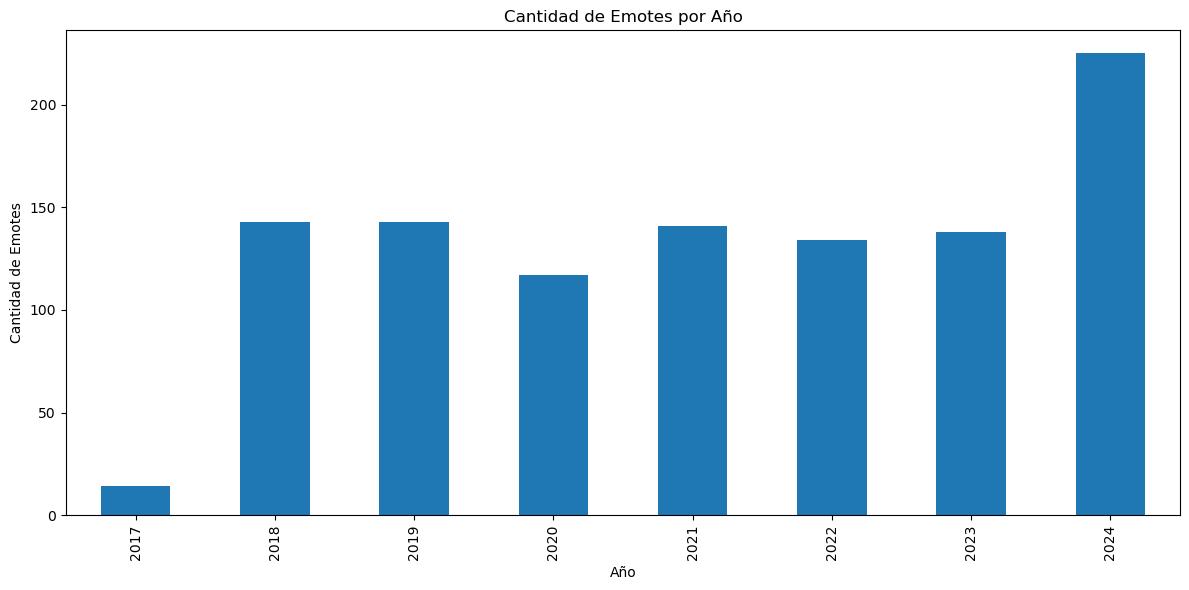

In [330]:
plt.figure(figsize=(12, 6))
year_counts = df_emotes_clean['año'].value_counts().sort_index()
year_counts.plot(kind='bar')
plt.title('Cantidad de Emotes por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Emotes')
plt.tight_layout()
plt.show()

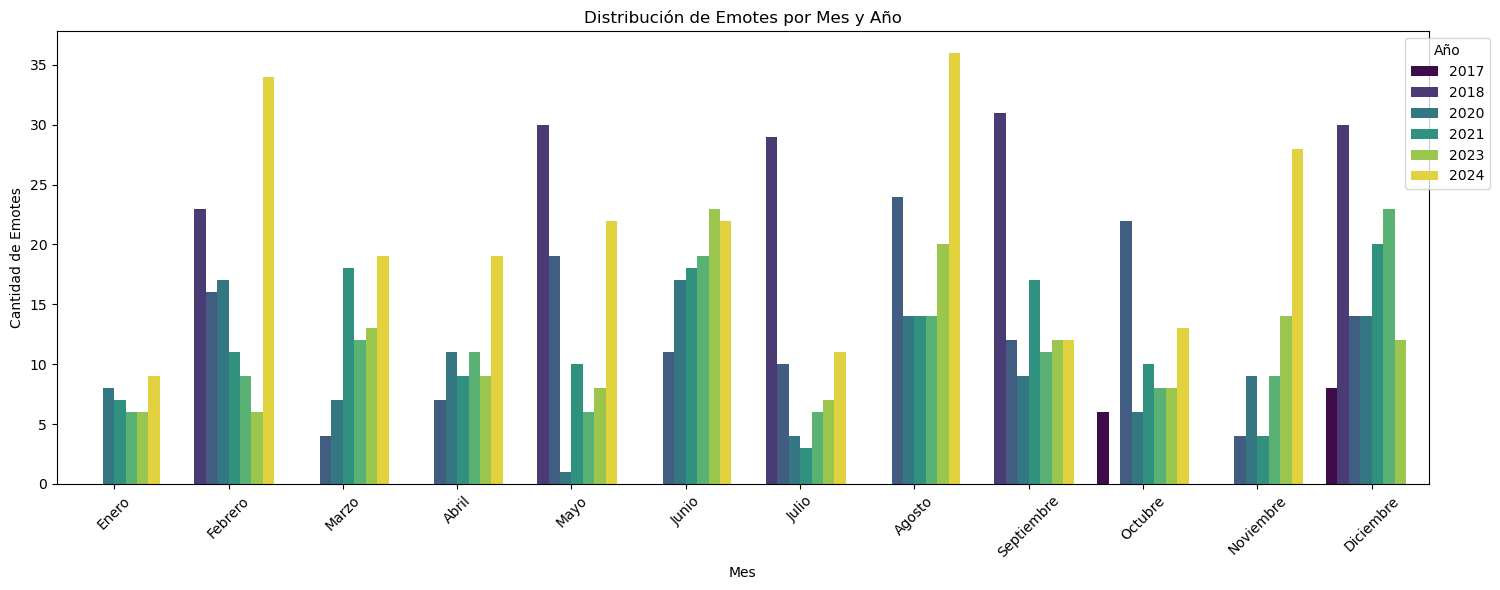

In [331]:
# Crear el gráfico
meses = ['Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio', 
         'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre']
plt.figure(figsize=(15, 6))
sns.countplot(data=df_emotes_clean, x='mes', hue='año', palette='viridis')
plt.title('Distribución de Emotes por Mes y Año')
plt.xlabel('Mes')
plt.ylabel('Cantidad de Emotes')
plt.xticks(range(12), meses, rotation=45)
plt.legend(title='Año', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

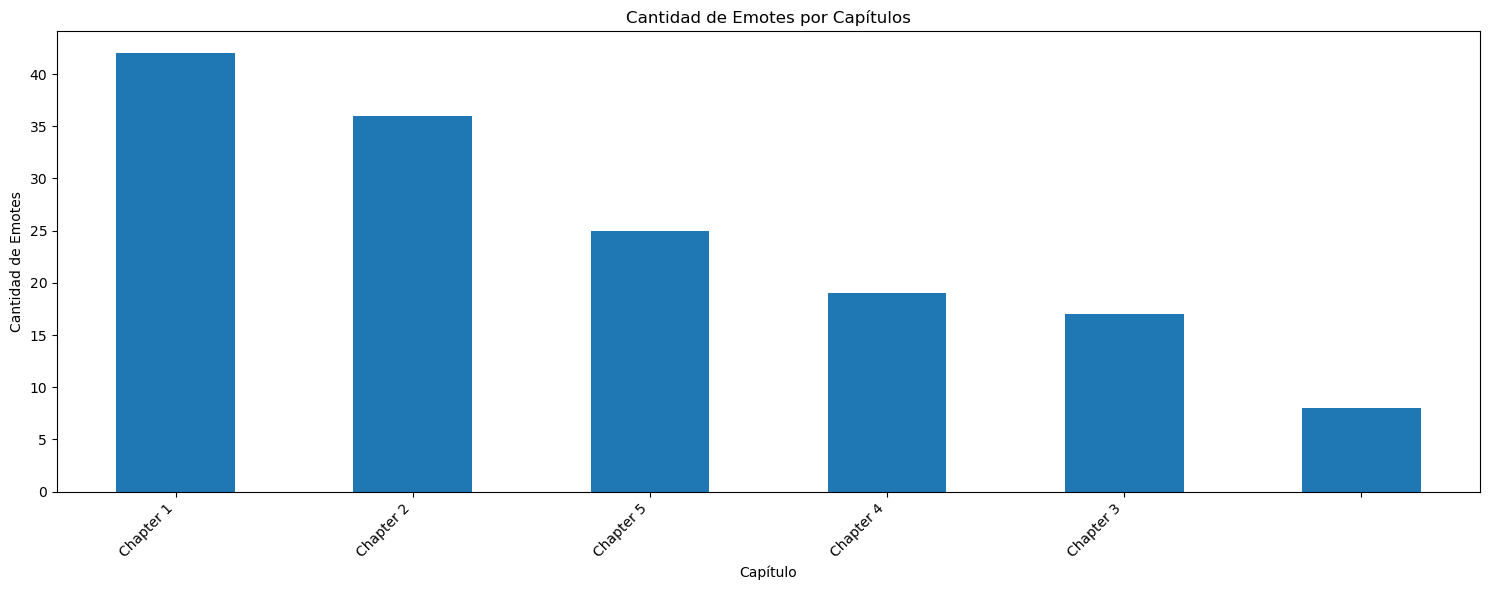

In [332]:
plt.figure(figsize=(15, 6))
season_counts = df_emotes_clean['battlepass_displayText_chapter'].value_counts()
season_counts.plot(kind='bar')
plt.title('Cantidad de Emotes por Capítulos')
plt.xlabel('Capítulo')
plt.ylabel('Cantidad de Emotes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

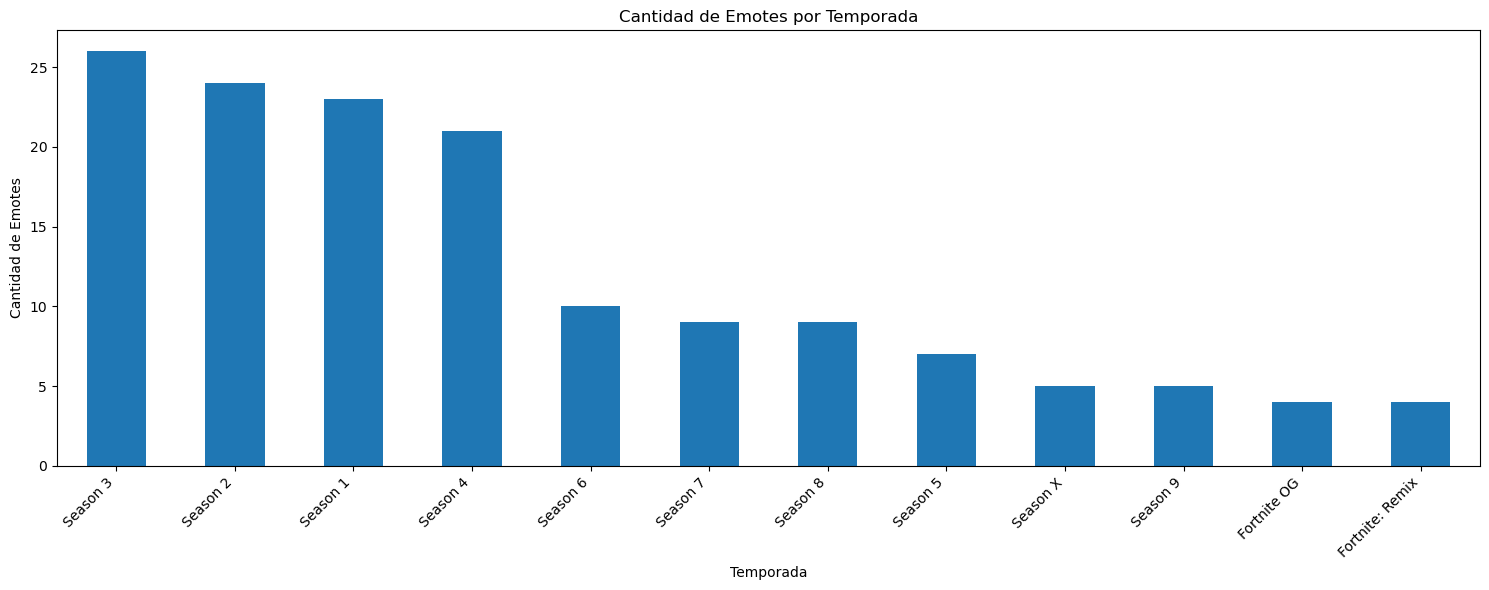

In [333]:
plt.figure(figsize=(15, 6))
season_counts = df_emotes_clean['battlepass_displayText_season'].value_counts()
season_counts.plot(kind='bar')
plt.title('Cantidad de Emotes por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Cantidad de Emotes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

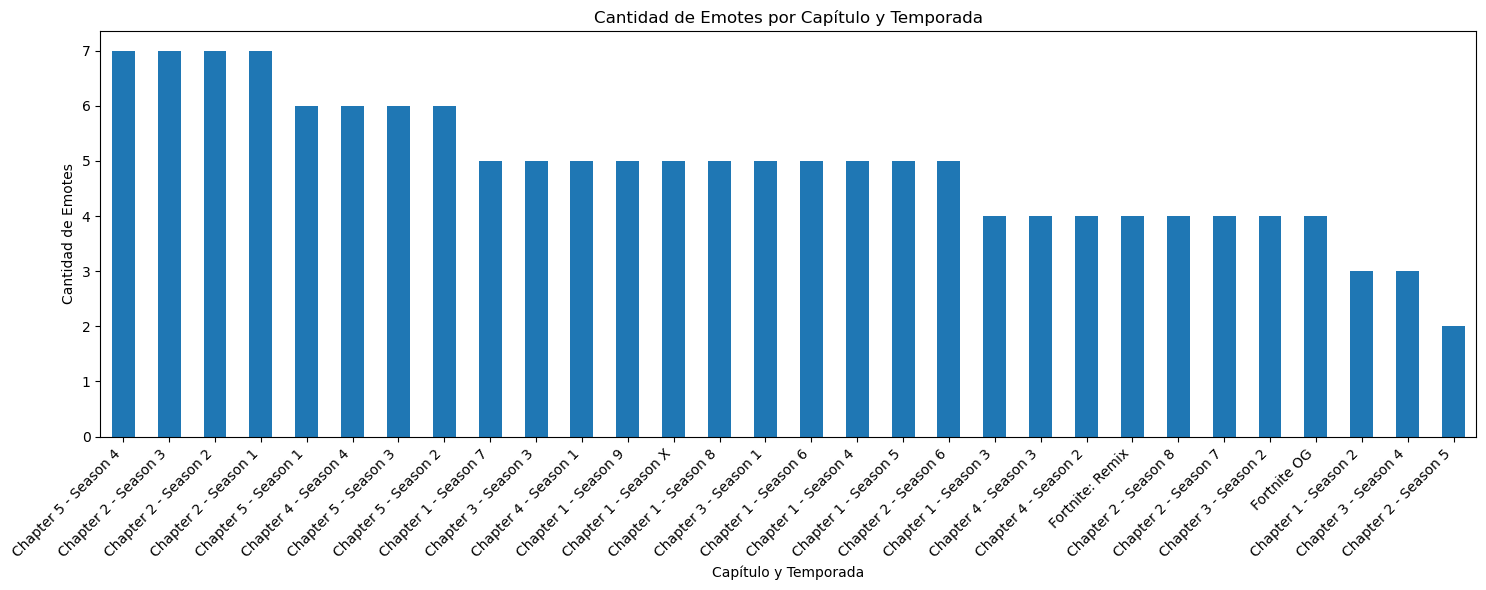

In [334]:
plt.figure(figsize=(15, 6))
season_counts = df_emotes_clean['battlepass_displayText_chapterSeason'].value_counts()
season_counts.plot(kind='bar')
plt.title('Cantidad de Emotes por Capítulo y Temporada')
plt.xlabel('Capítulo y Temporada')
plt.ylabel('Cantidad de Emotes')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [335]:
# Análisis de la temporada

# Se observa un crecimiento constante en la cantidad de emotes lanzados desde 2017 hasta 2024, 
# con un incremento especialmente notable en los últimos años.

# Puntos de interés:
#	•	El año 2017 tiene una cantidad mínima, probablemente debido al inicio del juego y la definición del modelo 
#        de negocio con la tienda de objetos cosmeticos.
#	•	El año 2024 destaca como el más prolífico en cuanto a emotes lanzados.
#	•	Implicaciones: Esto puede reflejar un interés creciente por parte de epic games de expandir la oferta 
#        de emotes para mantener la atención de la comunidad (además de ser un negocio).

# Distribución de Emotes por Mes y Año

#	•	Patrones mensuales: Los meses de mayor actividad en lanzamientos parecen variar año a año, 
#       pero hay una tendencia a concentrar lanzamientos en meses específicos (posiblemente alineados 
#       con eventos o temporadas de alto interés, como festividades o temporadas nuevas).

# Cantidad de Emotes por Temporada

#	•	Patrones estacionales: Temporadas específicas (como Season 2 y Season 3) destacan con un mayor 
#       número de emotes lanzados, mientras que otras tienen un menor número.

# Cantidad de Emotes por Capítulo

#	•	Distribución: Chapter 1 y Chapter 2 tienen la mayor cantidad de emotes lanzados, seguidos por 
#       capítulos posteriores con una cantidad más moderada.
# 
#	•	Esto podría reflejar la popularidad del juego en sus etapas iniciales y una estabilización en el 
#       número de lanzamientos conforme el juego madura.

# Se podria analizar
#	•	Si la calidad o popularidad de los emotes por capítulo podría revelar si la percepción de 
# los usuarios cambia con el tiempo.


#### Análisis por popularidad

In [336]:
# Para la popularidad emplearé dos enfoques:
#	•	Utilizando el dato que da epic games sobre el interes de los usuarios por cada emote
#	•	Haciendo un scraping a fortnitegg para obtener el interes de los usuarios por cada emote

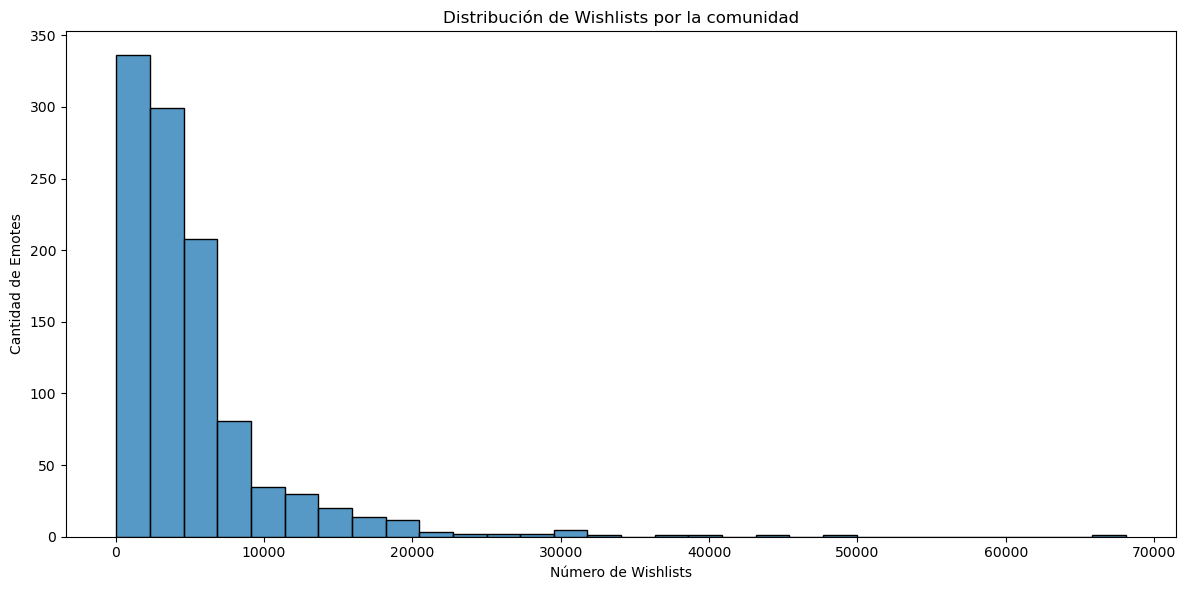

In [337]:
# 1. Distribución general de popularidad
plt.figure(figsize=(12, 6))
sns.histplot(data=df_emotes_clean, x='wishlists', bins=30)
plt.title('Distribución de Wishlists por la comunidad')
plt.xlabel('Número de Wishlists')
plt.ylabel('Cantidad de Emotes')
plt.tight_layout()
plt.show()

In [338]:
# 2. Top emotes más populares
print("\nTop 10 emotes más deseados:")
print(df_emotes_clean.nlargest(10, 'wishlists')[['name', 'wishlists', 'price', 'rarity_id']])



Top 10 emotes más deseados:
                name  wishlists  price rarity_id
846       Take The L      68088      0      Rare
193       Get Griddy      49682    500      Rare
63   Jabba Switchway      44007    500      Rare
289      Laugh It Up      40352    500      Rare
871            Floss      37120      0      Rare
62         Go Mufasa      32241    500      Rare
150   Rushin' Around      30912    500      Rare
855   Orange Justice      30539      0      Rare
20             Fresh      30242    800      Epic
455      Head Banger      29719    300      Epic


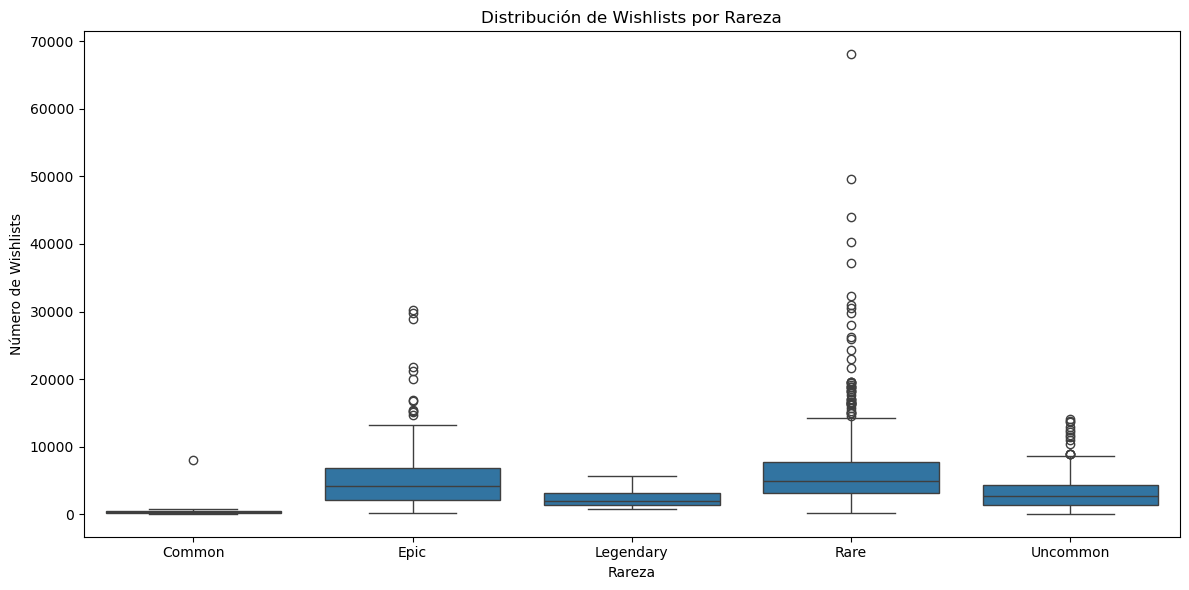

In [339]:
# 3. Análisis por rareza
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_emotes_clean, x='rarity_id', y='wishlists')
plt.title('Distribución de Wishlists por Rareza')
plt.xlabel('Rareza')
plt.ylabel('Número de Wishlists')
plt.tight_layout()
plt.show()

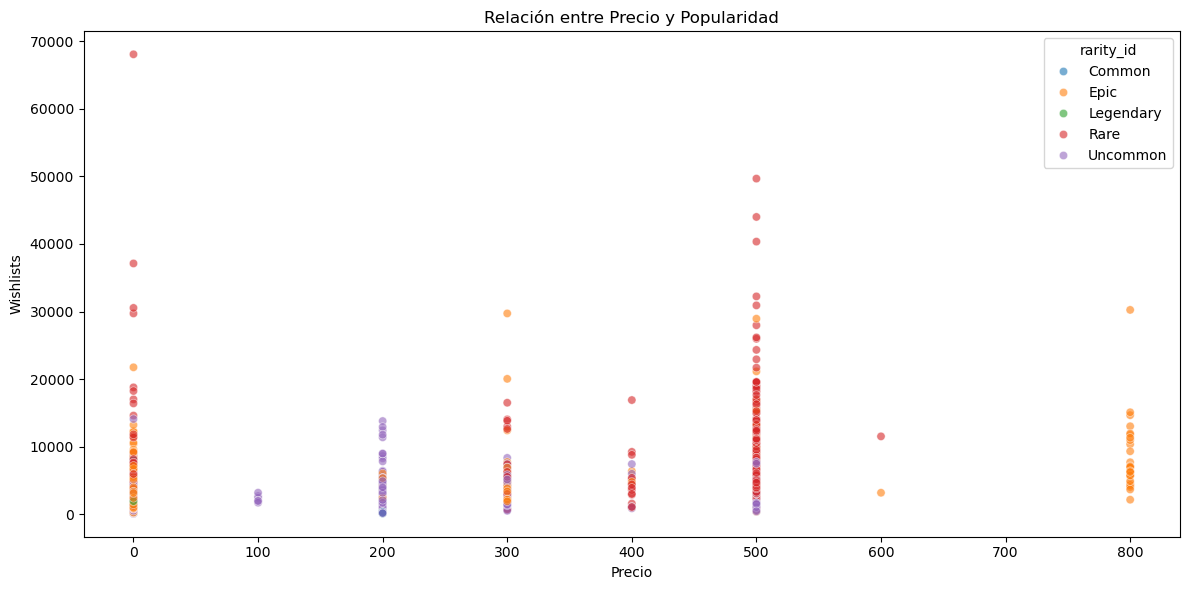

In [340]:
# 4. Correlación entre precio y popularidad
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_emotes_clean, x='price', y='wishlists', hue='rarity_id', alpha=0.6)
plt.title('Relación entre Precio y Popularidad')
plt.xlabel('Precio')
plt.ylabel('Wishlists')
plt.tight_layout()
plt.show()

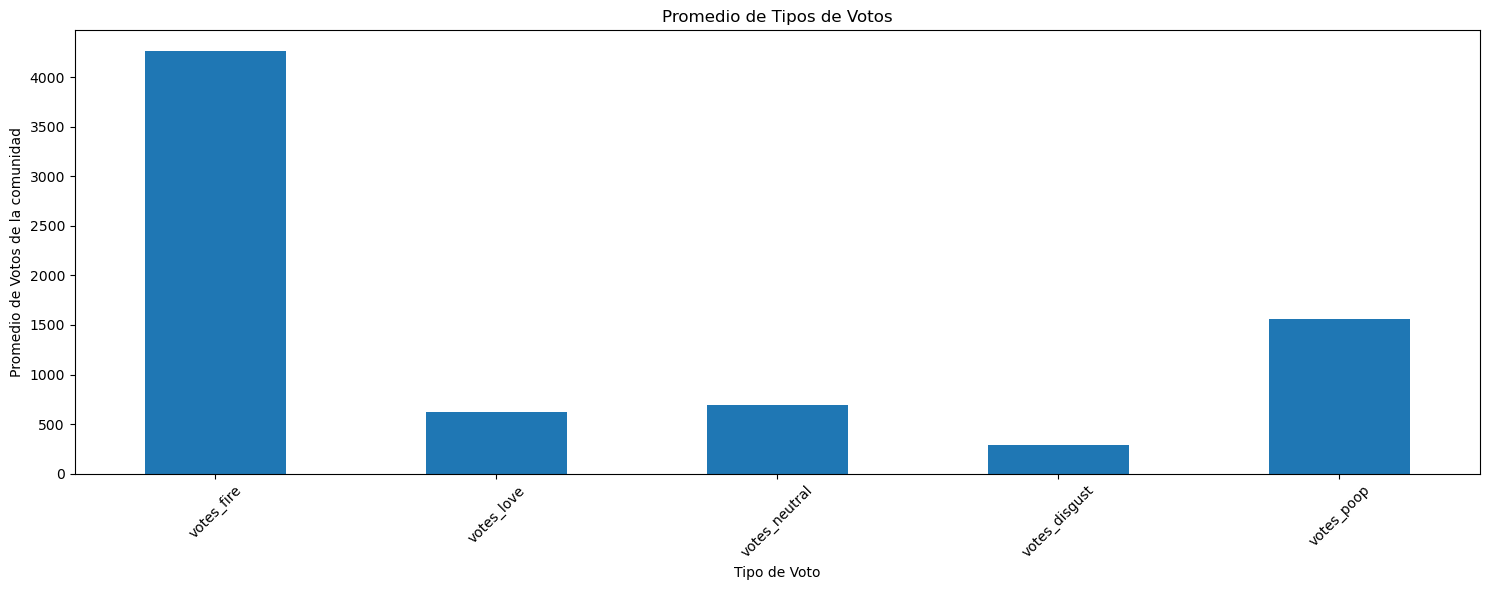

In [341]:
# 5. Análisis de votos
vote_columns = ['votes_fire', 'votes_love', 'votes_neutral', 'votes_disgust', 'votes_poop']
plt.figure(figsize=(15, 6))
df_emotes_clean[vote_columns].mean().plot(kind='bar')
plt.title('Promedio de Tipos de Votos')
plt.xlabel('Tipo de Voto')
plt.ylabel('Promedio de Votos de la comunidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

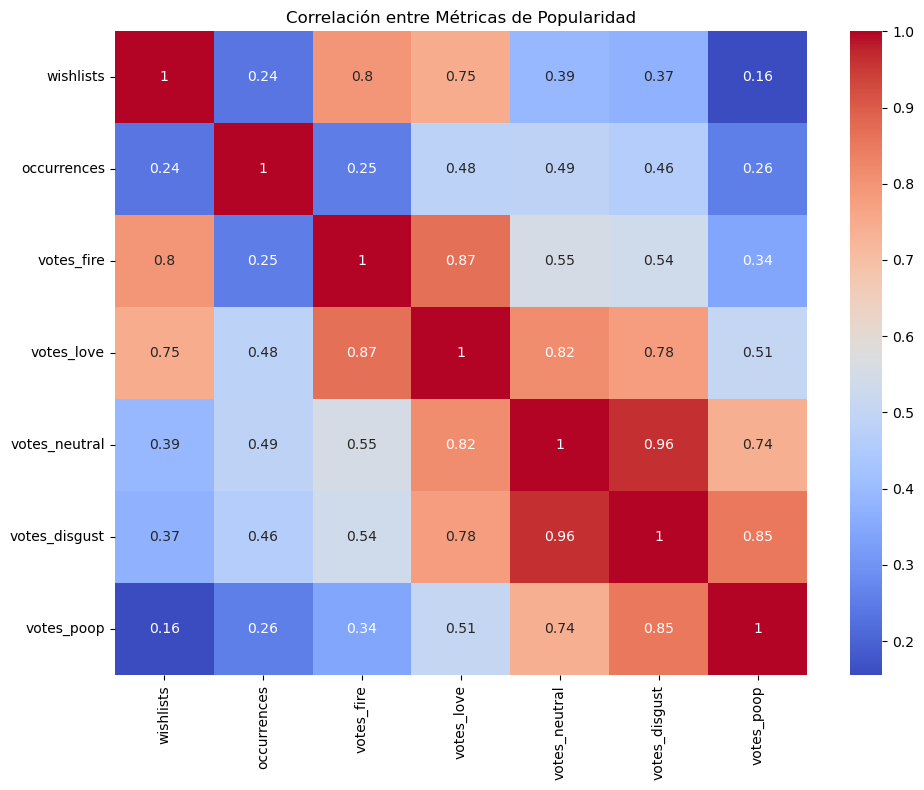

In [342]:
# 6. Correlación entre diferentes métricas de popularidad
correlation_matrix = df_emotes_clean[['wishlists', 'occurrences'] + vote_columns].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlación entre Métricas de Popularidad')
plt.tight_layout()
plt.show()

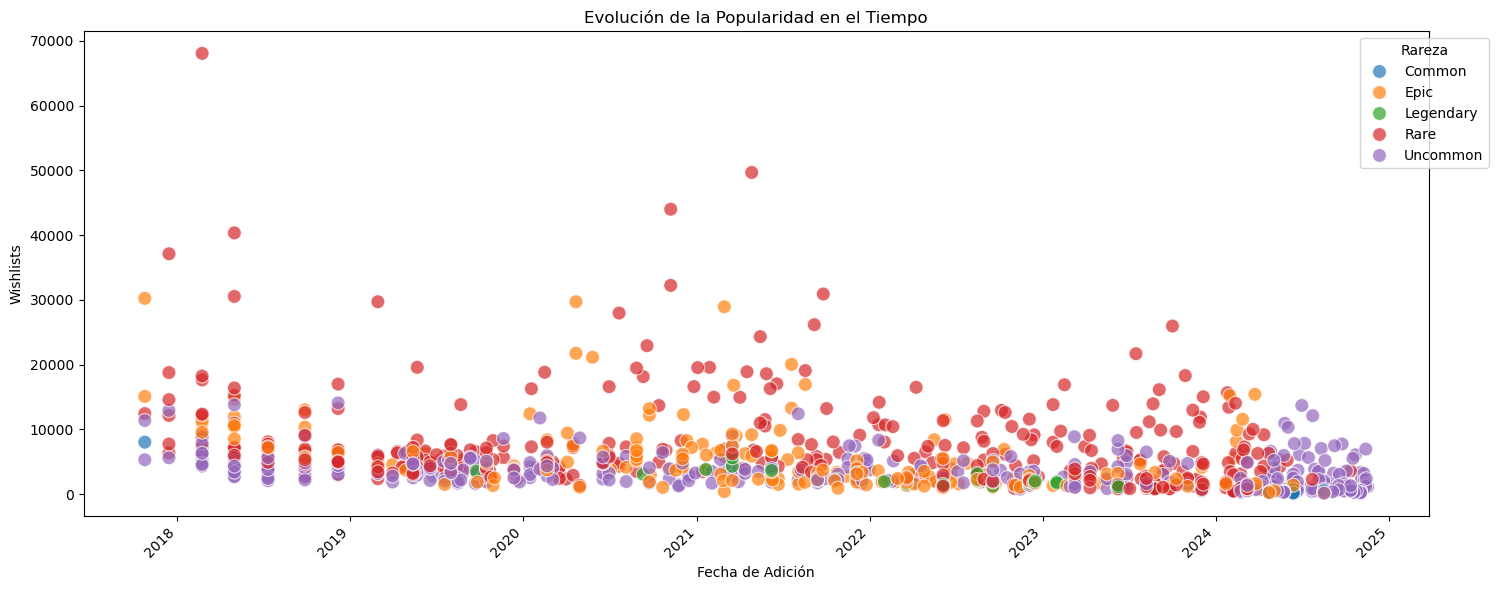

In [343]:
# Visualización por mes y año
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df_emotes_clean, 
                x='added_date', 
                y='wishlists', 
                hue='rarity_id',
                s=100,
                alpha=0.7)
plt.title('Evolución de la Popularidad en el Tiempo')
plt.xlabel('Fecha de Adición')
plt.ylabel('Wishlists')
plt.legend(title='Rareza', bbox_to_anchor=(1.05, 1))
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [344]:
# 8. Estadísticas descriptivas
print("\nEstadísticas de popularidad:")
print(df_emotes[['wishlists', 'occurrences'] + vote_columns].describe())



Estadísticas de popularidad:
          wishlists  occurrences    votes_fire   votes_love  votes_neutral  \
count   1055.000000  1055.000000   1055.000000  1055.000000    1055.000000   
mean    5085.452133    19.927014   4262.184834   623.019905     697.018957   
std     5559.990241    24.043473   6971.115650   650.392206     651.202564   
min       57.000000     0.000000      0.000000     0.000000       0.000000   
25%     1913.500000     0.000000    920.000000   186.000000     210.500000   
50%     3755.000000    12.000000   2000.000000   383.000000     463.000000   
75%     6158.000000    31.000000   4700.000000   829.000000     988.500000   
max    68088.000000   148.000000  96500.000000  5200.000000    6000.000000   

       votes_disgust    votes_poop  
count    1055.000000   1055.000000  
mean      283.734597   1560.573460  
std       295.870064   2738.984886  
min         0.000000      0.000000  
25%        79.000000    257.000000  
50%       182.000000    678.000000  
75%     

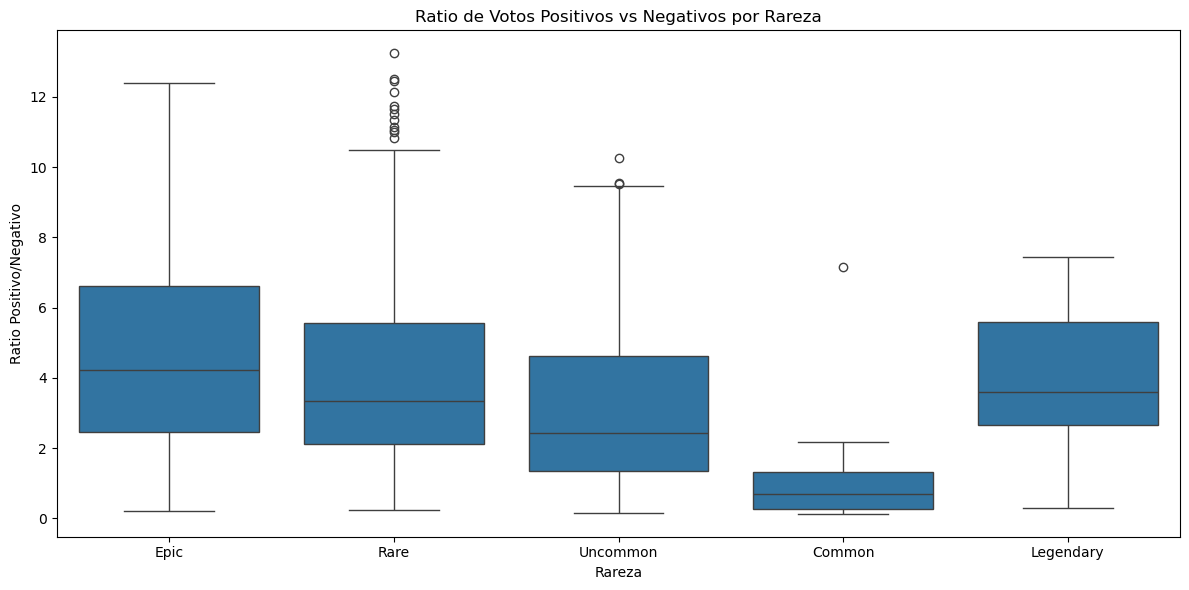

In [345]:
# 9. Ratio de votos positivos vs negativos
df_emotes['positive_ratio'] = (df_emotes['votes_fire'] + df_emotes['votes_love']) / \
                             (df_emotes['votes_disgust'] + df_emotes['votes_poop'])

plt.figure(figsize=(12, 6))
sns.boxplot(data=df_emotes, x='rarity_id', y='positive_ratio')
plt.title('Ratio de Votos Positivos vs Negativos por Rareza')
plt.xlabel('Rareza')
plt.ylabel('Ratio Positivo/Negativo')
plt.tight_layout()
plt.show()

<Figure size 1500x600 with 0 Axes>

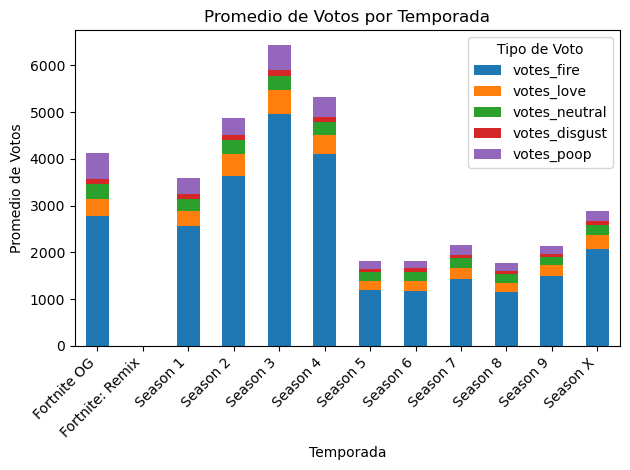

In [346]:
# Visualización de votos promedio por temporada
plt.figure(figsize=(15, 6))
season_avg_votes = df_emotes.groupby('battlepass_displayText_season')[
    ['votes_fire', 'votes_love', 'votes_neutral', 'votes_disgust', 'votes_poop']
].mean()
season_avg_votes.plot(kind='bar', stacked=True)
plt.title('Promedio de Votos por Temporada')
plt.xlabel('Temporada')
plt.ylabel('Promedio de Votos')
plt.legend(title='Tipo de Voto')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

Estadísticas:

Interés (Epic):
count    1055.000000
mean        0.126872
std         0.417066
min         0.000000
25%         0.000000
50%         0.030000
75%         0.090000
max         6.410000
Name: interest, dtype: float64

Ratio de la comunidad (votos positivos/negativos):
count    1055.000000
mean        3.742939
std         2.652937
min         0.000000
25%         1.754970
50%         3.072848
75%         5.349048
max        13.231616
Name: community_ratio, dtype: float64

Test de normalidad:
Interés (Epic):
Estadístico: 0.2796, p-valor: 0.0000

Ratio comunidad:
Estadístico: 0.9323, p-valor: 0.0000

Correlaciones:
Pearson: r=0.2388, p-valor=0.0000
Spearman: ρ=0.2931, p-valor=0.0000

Test de Wilcoxon:
Estadístico: 765.0000, p-valor: 0.0000


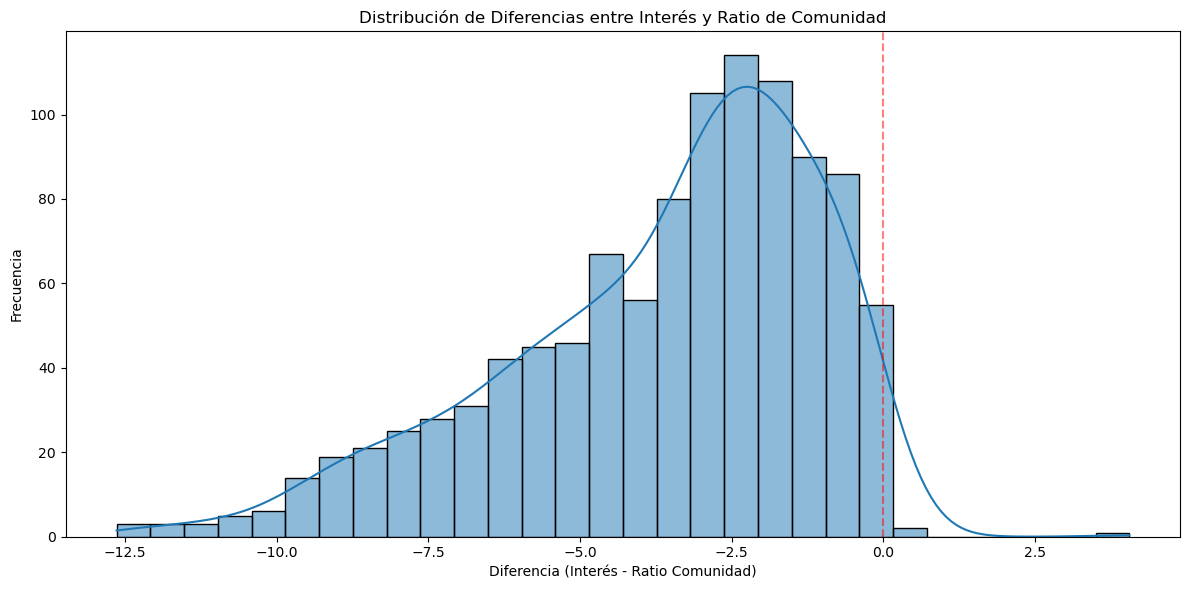

In [347]:
#Analisis de la popularidad de la comunidad vs la indicada por epic

# 1. Crear el community ratio
df_stats = df_emotes_clean.copy()

# Calcular el ratio (votos positivos / votos negativos)
df_stats['community_ratio'] = (df_stats['votes_fire'] + df_stats['votes_love']) / \
                             (df_stats['votes_disgust'] + df_stats['votes_poop'] + 1)  # +1 para evitar división por cero

# Eliminar infinitos y NaN
df_stats = df_stats[
    np.isfinite(df_stats['interest']) & 
    np.isfinite(df_stats['community_ratio'])
]

# Ahora el análisis estadístico
from scipy import stats

# 1. Estadísticas 
print("Estadísticas:")
print("\nInterés (Epic):")
print(df_stats['interest'].describe())
print("\nRatio de la comunidad (votos positivos/negativos):")
print(df_stats['community_ratio'].describe())

# 2. Test de normalidad (Shapiro-Wilk)
print("\nTest de normalidad:")
print("Interés (Epic):")
stat_interest, p_interest = stats.shapiro(df_stats['interest'])
print(f"Estadístico: {stat_interest:.4f}, p-valor: {p_interest:.4f}")

print("\nRatio comunidad:")
stat_comm, p_comm = stats.shapiro(df_stats['community_ratio'])
print(f"Estadístico: {stat_comm:.4f}, p-valor: {p_comm:.4f}")

# 3. Correlación de Pearson y Spearman
pearson_corr, pearson_p = stats.pearsonr(df_stats['interest'], df_stats['community_ratio'])
spearman_corr, spearman_p = stats.spearmanr(df_stats['interest'], df_stats['community_ratio'])

print("\nCorrelaciones:")
print(f"Pearson: r={pearson_corr:.4f}, p-valor={pearson_p:.4f}")
print(f"Spearman: ρ={spearman_corr:.4f}, p-valor={spearman_p:.4f}")

# 4. Test de Wilcoxon para muestras relacionadas
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(df_stats['interest'], df_stats['community_ratio'])
print("\nTest de Wilcoxon:")
print(f"Estadístico: {wilcoxon_stat:.4f}, p-valor: {wilcoxon_p:.4f}")

# 5. Visualización de la distribución de diferencias
plt.figure(figsize=(12, 6))
sns.histplot(data=df_stats, x=df_stats['interest'] - df_stats['community_ratio'], bins=30, kde=True)
plt.title('Distribución de Diferencias entre Interés y Ratio de Comunidad')
plt.xlabel('Diferencia (Interés - Ratio Comunidad)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [348]:
"""
El interés de Epic tiene una media muy baja (0.124) con una gran variabilidad 
El ratio de la comunidad es considerablemente más alto (media=3.813) con mayor variabilidad

Test de Normalidad
Ambas variables tienen p-valores < 0.05 (0.0000)
Esto indica que ninguna de las dos variables sigue una distribución normal

Correlaciones
Se observan correlaciones positivas débiles
La similitud entre Pearson y Spearman podria sugerir que la relación es aproximadamente lineal

Test de Wilcoxon:
El p-valor de 0.0000 indica una diferencia estadísticamente significativa entre las dos medidas
Esto sugiere que Epic y la comunidad tienen valoraciones sistemáticamente diferentes

En conclusión:
- Repetiré el análisis sin outliers
-Hasta ahora se podria concluir que: 
    - Hay una discrepancia significativa entre cómo Epic valora los emotes y cómo los valora la comunidad
    - La correlación positiva débil sugiere que Epic puede predecir la tendencia general pero no con gran precisión
    - La comunidad tiende a dar valoraciones más altas y más variables que Epic
    - Los datos de la comunidad pudieran no ser representativos de las ventas por epic games y este podria ser el dato empleado


"""

'\nEl interés de Epic tiene una media muy baja (0.124) con una gran variabilidad \nEl ratio de la comunidad es considerablemente más alto (media=3.813) con mayor variabilidad\n\nTest de Normalidad\nAmbas variables tienen p-valores < 0.05 (0.0000)\nEsto indica que ninguna de las dos variables sigue una distribución normal\n\nCorrelaciones\nSe observan correlaciones positivas débiles\nLa similitud entre Pearson y Spearman podria sugerir que la relación es aproximadamente lineal\n\nTest de Wilcoxon:\nEl p-valor de 0.0000 indica una diferencia estadísticamente significativa entre las dos medidas\nEsto sugiere que Epic y la comunidad tienen valoraciones sistemáticamente diferentes\n\nEn conclusión:\n- Repetiré el análisis sin outliers\n-Hasta ahora se podria concluir que: \n    - Hay una discrepancia significativa entre cómo Epic valora los emotes y cómo los valora la comunidad\n    - La correlación positiva débil sugiere que Epic puede predecir la tendencia general pero no con gran precisi

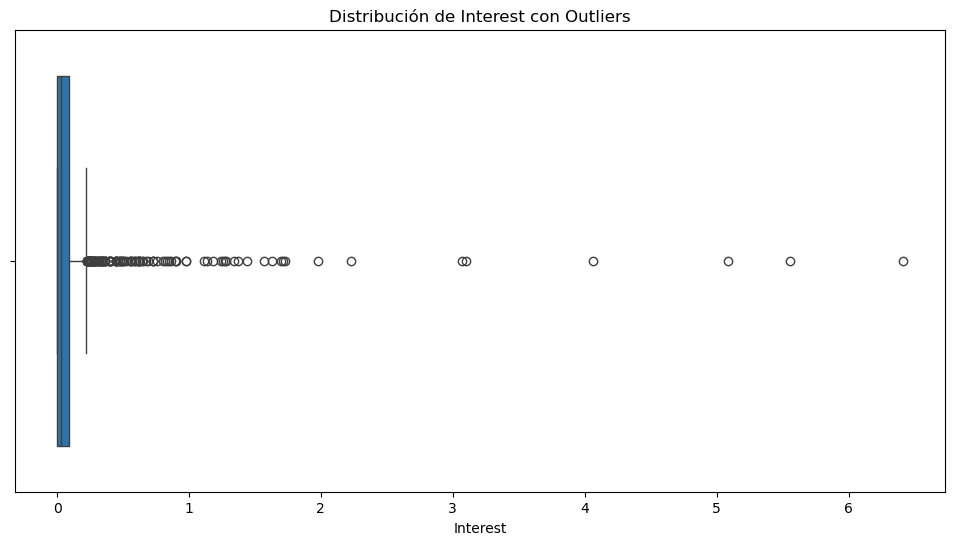


Estadísticas de Interest:
Q1: 0.0
Q3: 0.09
IQR: 0.09
Límite inferior: -0.135
Límite superior: 0.225

Número de outliers: 122

Top 10 outliers más extremos:
                      name  interest  community_ratio rarity_id
1044  Crowning Achievement      6.41         6.469541      Epic
193             Get Griddy      5.56        10.817998      Rare
170           Popular Vibe      5.09         6.074494      Rare
720         Cauldron Chill      4.06         0.000000  Uncommon
893            Dance Moves      3.10         7.153261    Common
766            Boogie Down      3.07        10.264901      Epic
33                 Starlit      2.23        10.471204      Rare
289            Laugh It Up      1.98         3.851926      Rare
362            Bye Bye Bye      1.73        10.252427  Uncommon
354           Billy Bounce      1.71        12.500000      Rare


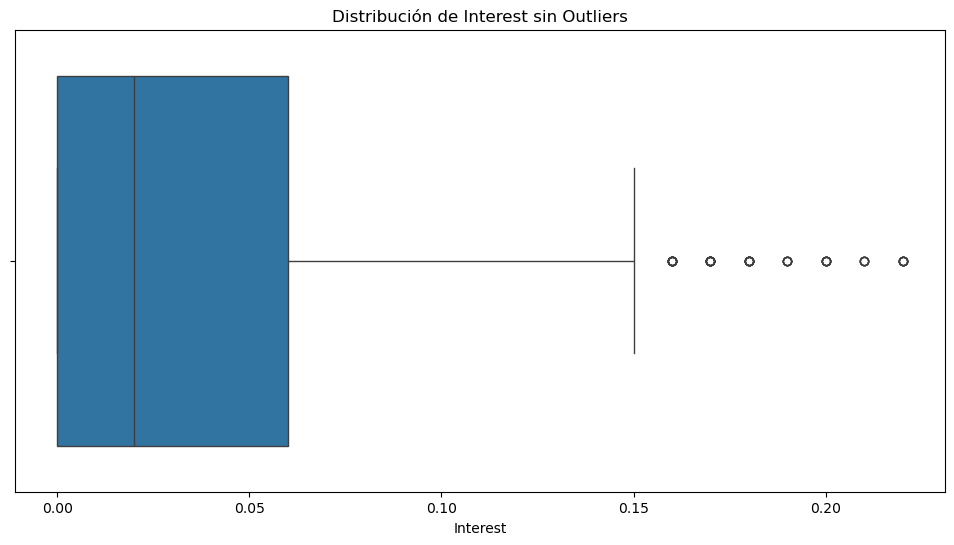


Estadísticas con outliers:
count    1055.000000
mean        0.126872
std         0.417066
min         0.000000
25%         0.000000
50%         0.030000
75%         0.090000
max         6.410000
Name: interest, dtype: float64

Estadísticas sin outliers:
count    933.000000
mean       0.039378
std        0.050487
min        0.000000
25%        0.000000
50%        0.020000
75%        0.060000
max        0.220000
Name: interest, dtype: float64


In [349]:
# 1. Visualizar la distribución actual con boxplot
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_stats['interest'])
plt.title('Distribución de Interest con Outliers')
plt.xlabel('Interest')
plt.show()

# 2. Calcular límites usando el método IQR
Q1 = df_stats['interest'].quantile(0.25)
Q3 = df_stats['interest'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print("\nEstadísticas de Interest:")
print(f"Q1: {Q1}")
print(f"Q3: {Q3}")
print(f"IQR: {IQR}")
print(f"Límite inferior: {lower_bound}")
print(f"Límite superior: {upper_bound}")

# 3. Identificar outliers
outliers = df_stats[
    (df_stats['interest'] < lower_bound) | 
    (df_stats['interest'] > upper_bound)
]

print(f"\nNúmero de outliers: {len(outliers)}")
print("\nTop 10 outliers más extremos:")
print(outliers.nlargest(10, 'interest')[['name', 'interest', 'community_ratio', 'rarity_id']])

# 4. Crear dataset limpio
df_stats_clean = df_stats[
    (df_stats['interest'] >= lower_bound) & 
    (df_stats['interest'] <= upper_bound)
]

# 5. Visualizar distribución limpia
plt.figure(figsize=(12, 6))
sns.boxplot(x=df_stats_clean['interest'])
plt.title('Distribución de Interest sin Outliers')
plt.xlabel('Interest')
plt.show()

# 6. Comparar estadísticas antes y después
print("\nEstadísticas con outliers:")
print(df_stats['interest'].describe())
print("\nEstadísticas sin outliers:")
print(df_stats_clean['interest'].describe())

Estadísticas:

Interés (Epic):
count    933.000000
mean       0.039378
std        0.050487
min        0.000000
25%        0.000000
50%        0.020000
75%        0.060000
max        0.220000
Name: interest, dtype: float64

Ratio de la comunidad (votos positivos/negativos):
count    933.000000
mean       3.479121
std        2.464564
min        0.000000
25%        1.649074
50%        2.865103
75%        4.818560
max       12.451985
Name: community_ratio, dtype: float64

Test de normalidad:
Interés (Epic):
Estadístico: 0.7715, p-valor: 0.0000

Ratio comunidad:
Estadístico: 0.9284, p-valor: 0.0000

Correlaciones:
Pearson: r=0.2449, p-valor=0.0000
Spearman: ρ=0.2040, p-valor=0.0000

Test de Wilcoxon:
Estadístico: 0.0000, p-valor: 0.0000


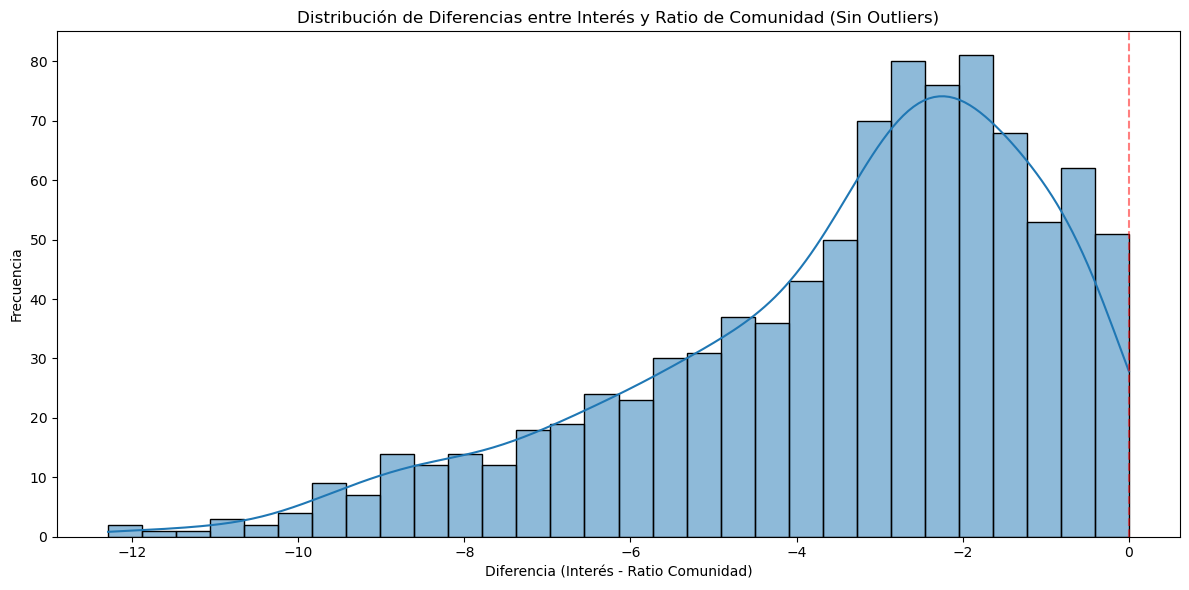

In [350]:
# Análisis estadístico con datos limpios
from scipy import stats

# 1. Estadísticas descriptivas
print("Estadísticas:")
print("\nInterés (Epic):")
print(df_stats_clean['interest'].describe())
print("\nRatio de la comunidad (votos positivos/negativos):")
print(df_stats_clean['community_ratio'].describe())

# 2. Test de normalidad (Shapiro-Wilk)
print("\nTest de normalidad:")
print("Interés (Epic):")
stat_interest, p_interest = stats.shapiro(df_stats_clean['interest'])
print(f"Estadístico: {stat_interest:.4f}, p-valor: {p_interest:.4f}")

print("\nRatio comunidad:")
stat_comm, p_comm = stats.shapiro(df_stats_clean['community_ratio'])
print(f"Estadístico: {stat_comm:.4f}, p-valor: {p_comm:.4f}")

# 3. Correlación de Pearson y Spearman
pearson_corr, pearson_p = stats.pearsonr(df_stats_clean['interest'], df_stats_clean['community_ratio'])
spearman_corr, spearman_p = stats.spearmanr(df_stats_clean['interest'], df_stats_clean['community_ratio'])

print("\nCorrelaciones:")
print(f"Pearson: r={pearson_corr:.4f}, p-valor={pearson_p:.4f}")
print(f"Spearman: ρ={spearman_corr:.4f}, p-valor={spearman_p:.4f}")

# 4. Test de Wilcoxon para muestras relacionadas
wilcoxon_stat, wilcoxon_p = stats.wilcoxon(df_stats_clean['interest'], df_stats_clean['community_ratio'])
print("\nTest de Wilcoxon:")
print(f"Estadístico: {wilcoxon_stat:.4f}, p-valor: {wilcoxon_p:.4f}")

# 5. Visualización de la distribución de diferencias
plt.figure(figsize=(12, 6))
sns.histplot(data=df_stats_clean, x=df_stats_clean['interest'] - df_stats_clean['community_ratio'], bins=30, kde=True)
plt.title('Distribución de Diferencias entre Interés y Ratio de Comunidad (Sin Outliers)')
plt.xlabel('Diferencia (Interés - Ratio Comunidad)')
plt.ylabel('Frecuencia')
plt.axvline(x=0, color='r', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [351]:
"""
Analisis sin outliers

Interest:
Media bajó significativamente: 0.124 → 0.040
Desviación estándar se redujo drásticamente: 0.402 → 0.051
Rango más acotado: [0, 6.41] → [0, 0.22]

Community Ratio:
Media bajó ligeramente: 3.813 → 3.541
Desviación estándar se redujo: 2.637 → 2.452
Rango similar pero máximo menor: [0.13, 13.23] → [0.13, 12.46]

-2 Test de Normalidad:

Interest:
Mejoró el estadístico Shapiro-Wilk: 0.2819 → 0.7757
Sigue sin ser normal (p < 0.05)

Community Ratio:
Similar estadístico: 0.9290 → 0.9248
Sigue sin ser normal (p < 0.05)

-3 Correlaciones:
Pearson: Disminuyó ligeramente (0.2632 → 0.2321)
Spearman: Disminuyó más notablemente (0.2822 → 0.1781)
Ambas siguen siendo significativas (p < 0.05)

-4 Test de Wilcoxon:
Mantiene el mismo resultado (p < 0.05)
Confirma que hay diferencias significativas entre las medidas

Conclusiones principales:
- La limpieza de outliers afectó principalmente a la variable 'interest'
- La correlación es más débil en los datos limpios
- Las diferencias entre Epic y la comunidad siguen siendo significativas
- La distribución de 'interest' mejoró pero sigue sin ser normal

Implicaciones:
- Epic tiende a dar valoraciones más conservadoras en general
- La relación entre la valoración de Epic y la comunidad es débil
- Podría haber factores adicionales que expliquen estas diferencias

"""

"\nAnalisis sin outliers\n\nInterest:\nMedia bajó significativamente: 0.124 → 0.040\nDesviación estándar se redujo drásticamente: 0.402 → 0.051\nRango más acotado: [0, 6.41] → [0, 0.22]\n\nCommunity Ratio:\nMedia bajó ligeramente: 3.813 → 3.541\nDesviación estándar se redujo: 2.637 → 2.452\nRango similar pero máximo menor: [0.13, 13.23] → [0.13, 12.46]\n\n-2 Test de Normalidad:\n\nInterest:\nMejoró el estadístico Shapiro-Wilk: 0.2819 → 0.7757\nSigue sin ser normal (p < 0.05)\n\nCommunity Ratio:\nSimilar estadístico: 0.9290 → 0.9248\nSigue sin ser normal (p < 0.05)\n\n-3 Correlaciones:\nPearson: Disminuyó ligeramente (0.2632 → 0.2321)\nSpearman: Disminuyó más notablemente (0.2822 → 0.1781)\nAmbas siguen siendo significativas (p < 0.05)\n\n-4 Test de Wilcoxon:\nMantiene el mismo resultado (p < 0.05)\nConfirma que hay diferencias significativas entre las medidas\n\nConclusiones principales:\n- La limpieza de outliers afectó principalmente a la variable 'interest'\n- La correlación es más 

#### Análisis por serie

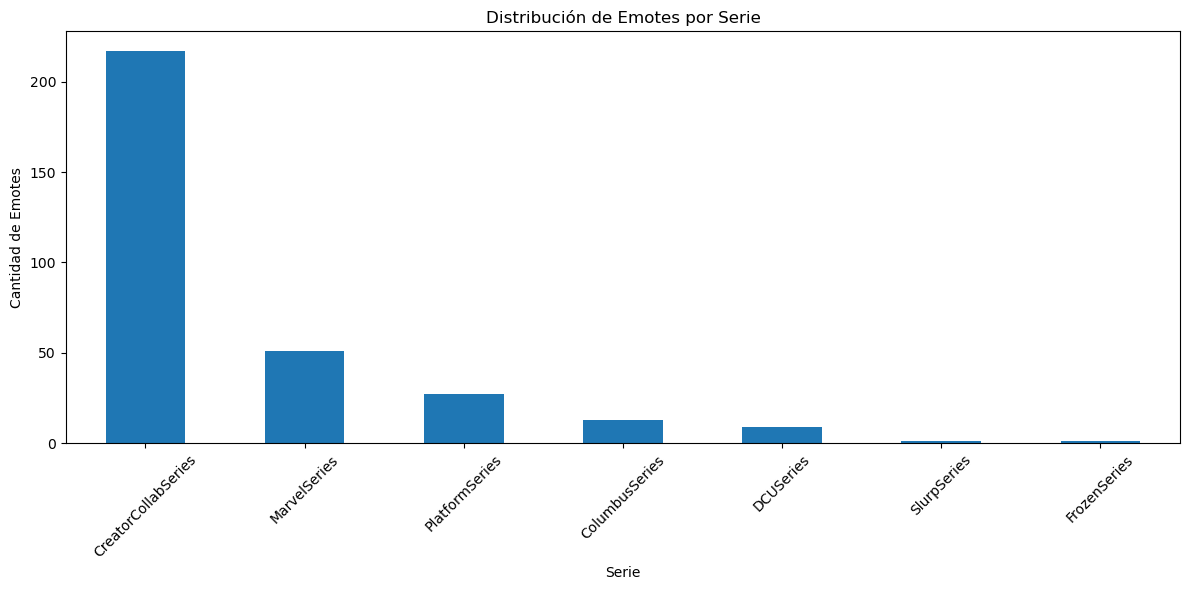

In [352]:
# 1. Distribución de emotes por serie
plt.figure(figsize=(12, 6))
df_emotes_clean['series_id'].value_counts().plot(kind='bar')
plt.title('Distribución de Emotes por Serie')
plt.xlabel('Serie')
plt.ylabel('Cantidad de Emotes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

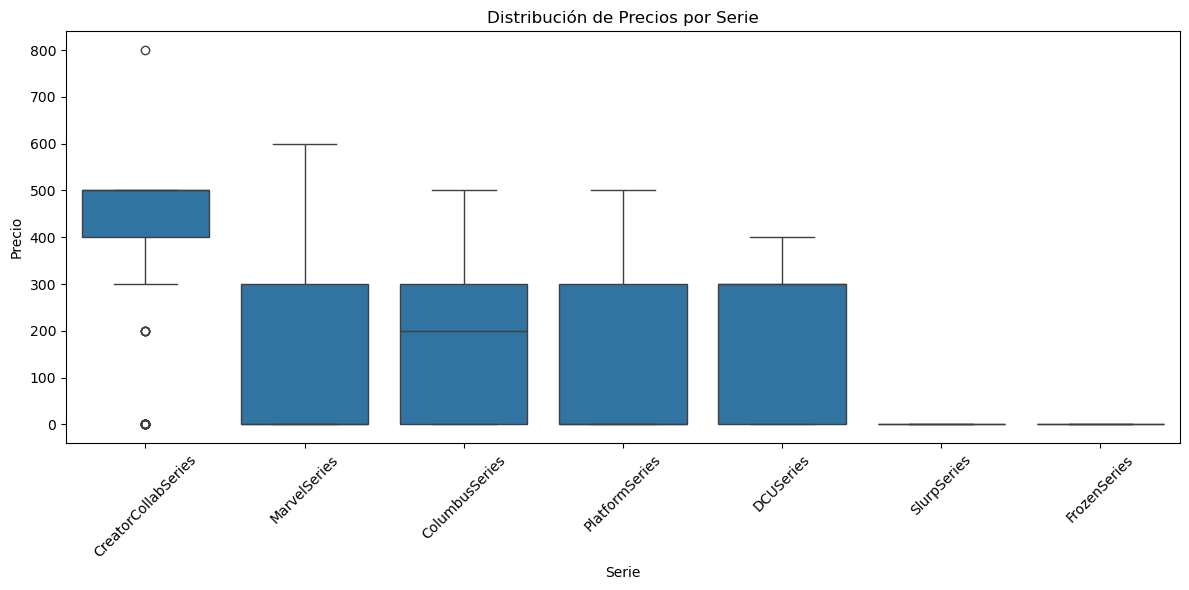

In [353]:
# 2. Distribución de precios por serie
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_emotes_clean[df_emotes_clean['series_id'].notna()], x='series_id', y='price')
plt.title('Distribución de Precios por Serie')
plt.xlabel('Serie')
plt.ylabel('Precio')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

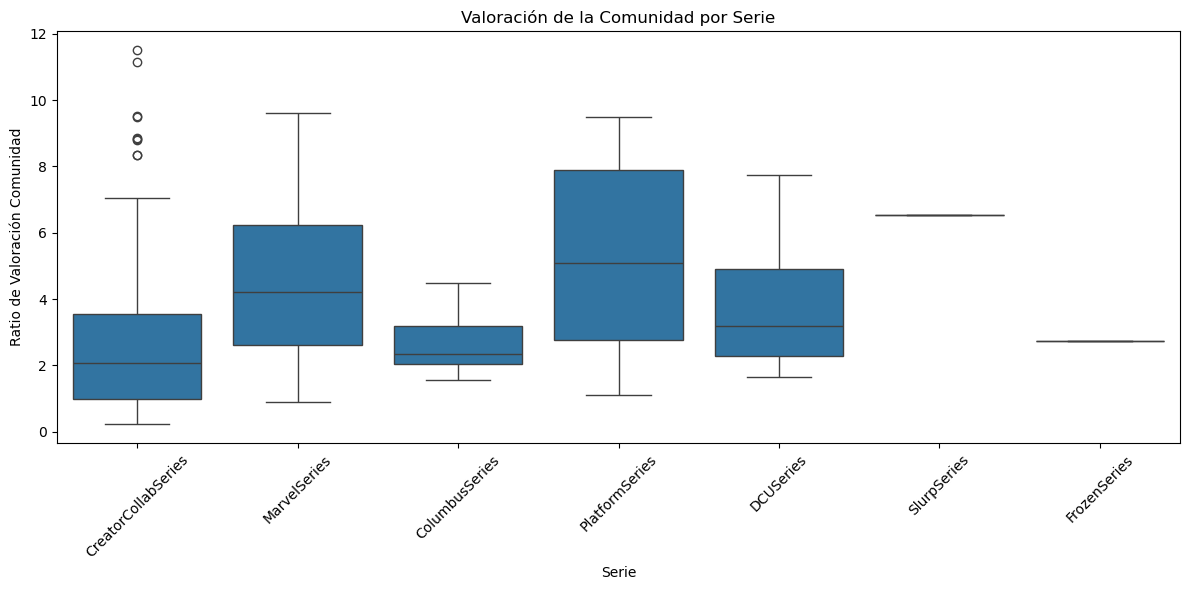

In [354]:
# 3. Valoración de la comunidad por serie
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_stats_clean[df_stats_clean['series_id'].notna()], 
            x='series_id', y='community_ratio')
plt.title('Valoración de la Comunidad por Serie')
plt.xlabel('Serie')
plt.ylabel('Ratio de Valoración Comunidad')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

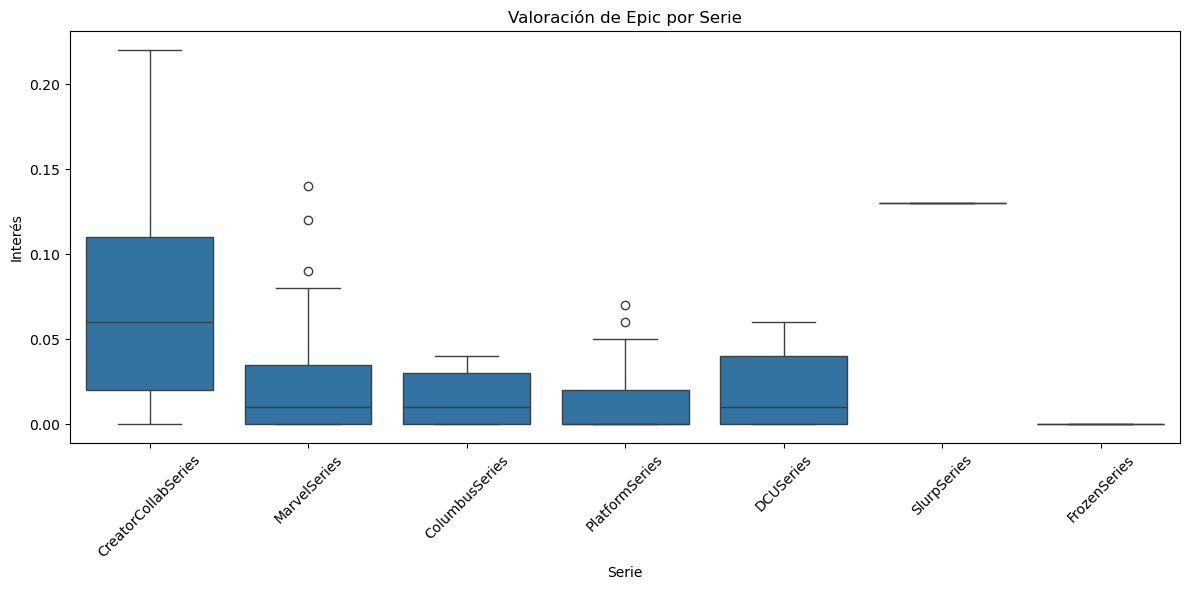

In [355]:
# 4. Valoración de Epic por serie
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_stats_clean[df_stats_clean['series_id'].notna()], 
            x='series_id', y='interest')
plt.title('Valoración de Epic por Serie')
plt.xlabel('Serie')
plt.ylabel('Interés')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<Figure size 1200x600 with 0 Axes>

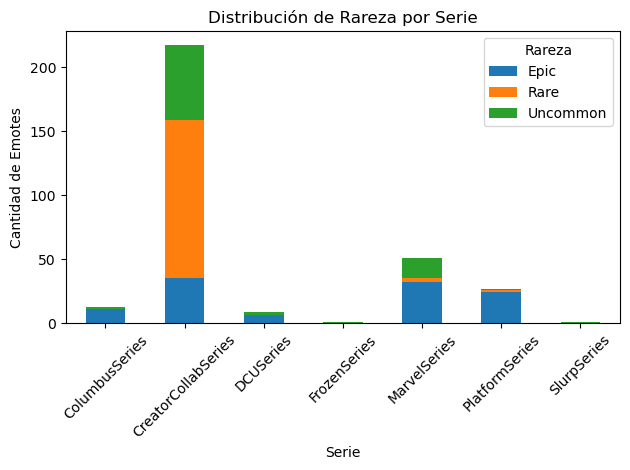

In [356]:
# 5. Distribución de rareza por serie
plt.figure(figsize=(12, 6))
series_rarity = pd.crosstab(df_emotes_clean['series_id'], df_emotes_clean['rarity_id'])
series_rarity.plot(kind='bar', stacked=True)
plt.title('Distribución de Rareza por Serie')
plt.xlabel('Serie')
plt.ylabel('Cantidad de Emotes')
plt.legend(title='Rareza')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [357]:
# 6. Tests estadísticos
# ANOVA para precio por serie
from scipy import stats

# Test para precio
series_groups_price = [group['price'].values for name, group in 
                      df_emotes_clean[df_emotes_clean['series_id'].notna()].groupby('series_id')]
f_stat_price, p_value_price = stats.f_oneway(*series_groups_price)

# Test para popularidad (wishlists)
series_groups_wish = [group['wishlists'].values for name, group in 
                     df_emotes_clean[df_emotes_clean['series_id'].notna()].groupby('series_id')]
f_stat_wish, p_value_wish = stats.f_oneway(*series_groups_wish)

# Test para occurrences
series_groups_occ = [group['occurrences'].values for name, group in 
                    df_emotes_clean[df_emotes_clean['series_id'].notna()].groupby('series_id')]
f_stat_occ, p_value_occ = stats.f_oneway(*series_groups_occ)

print("\nResultados de ANOVA:")
print(f"Precio por serie: F={f_stat_price:.4f}, p={p_value_price:.4f}")
print(f"Wishlists por serie: F={f_stat_wish:.4f}, p={p_value_wish:.4f}")
print(f"Occurrences por serie: F={f_stat_occ:.4f}, p={p_value_occ:.4f}")


Resultados de ANOVA:
Precio por serie: F=32.5770, p=0.0000
Wishlists por serie: F=9.8995, p=0.0000
Occurrences por serie: F=2.6660, p=0.0155


In [358]:
"""
Precio por Serie (F=32.5770, p=0.0000):
El F-statistic alto (32.5770) indica diferencias muy grandes entre grupos
El p-valor < 0.05 confirma que estas diferencias son estadísticamente significativas

Conclusión: Hay una fuerte evidencia estadistica de que los precios varían significativamente según la serie
(lo cual tiene sentido ya que epic games invierte bastante en marketing para hacer colaboraciones)

Wishlists por Serie (F=9.8995, p=0.0000):
F-statistic moderado (9.8995) indica diferencias notables entre grupos
P-valor < 0.05 confirma que estas diferencias son significativas
Conclusión: La popularidad (medida por wishlists) varía significativamente según la serie

Occurrences por Serie (F=2.6660, p=0.0155):
F-statistic más bajo (2.6660) indica diferencias más sutiles
P-valor < 0.05 pero más cercano que los anteriores
Conclusión: Hay diferencias significativas en las ocurrencias por serie, pero son menos pronunciadas

En general
La serie tiene un impacto muy fuerte en el precio
La serie influye moderadamente en la popularidad
La serie tiene un efecto más débil en las ocurrencias (veces disponible para comprar en la tienda)
"""

'\nPrecio por Serie (F=32.5770, p=0.0000):\nEl F-statistic alto (32.5770) indica diferencias muy grandes entre grupos\nEl p-valor < 0.05 confirma que estas diferencias son estadísticamente significativas\n\nConclusión: Hay una fuerte evidencia estadistica de que los precios varían significativamente según la serie\n(lo cual tiene sentido ya que epic games invierte bastante en marketing para hacer colaboraciones)\n\nWishlists por Serie (F=9.8995, p=0.0000):\nF-statistic moderado (9.8995) indica diferencias notables entre grupos\nP-valor < 0.05 confirma que estas diferencias son significativas\nConclusión: La popularidad (medida por wishlists) varía significativamente según la serie\n\nOccurrences por Serie (F=2.6660, p=0.0155):\nF-statistic más bajo (2.6660) indica diferencias más sutiles\nP-valor < 0.05 pero más cercano que los anteriores\nConclusión: Hay diferencias significativas en las ocurrencias por serie, pero son menos pronunciadas\n\nEn general\nLa serie tiene un impacto muy fu

In [359]:
# 7. Estadísticas  por serie
series_stats = df_emotes_clean.groupby('series_id').agg({
    'price': ['mean', 'std', 'count'],
    'interest': ['mean', 'max'],
    'wishlists': ['mean', 'max'],
    'occurrences': ['mean', 'max']
}).round(2)

print("\nEstadísticas por Serie:")
print(series_stats)


Estadísticas por Serie:
                      price               interest       wishlists         \
                       mean     std count     mean   max      mean    max   
series_id                                                                   
ColumbusSeries       184.62  207.55    13     0.03  0.27   2775.46   5485   
CreatorCollabSeries  419.35  159.26   217     0.26  5.56   9277.53  49682   
DCUSeries            211.11  161.59     9     0.02  0.06   4547.78   7459   
FrozenSeries           0.00     NaN     1     0.00  0.00   2491.00   2491   
MarvelSeries         125.49  186.38    51     0.17  1.63   3046.84   9437   
PlatformSeries       137.04  177.91    27     0.03  0.24   4528.56  12286   
SlurpSeries            0.00     NaN     1     0.13  0.13    517.00    517   

                    occurrences       
                           mean  max  
series_id                             
ColumbusSeries            37.85   98  
CreatorCollabSeries       27.54  108  
DCUSeries

#### Análisis por Rareza

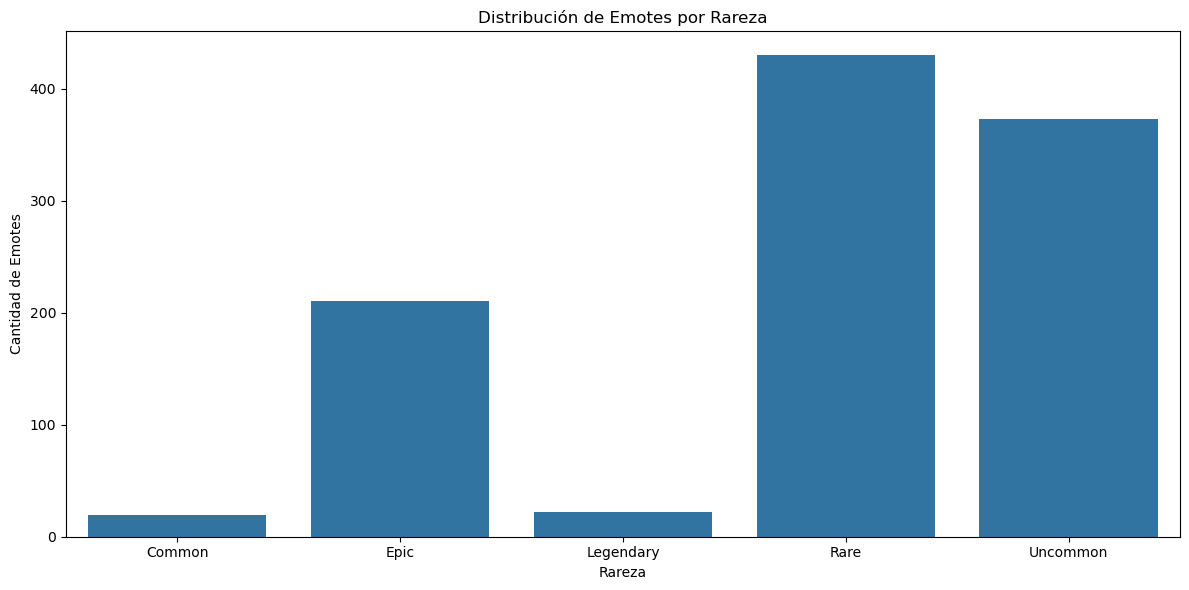

In [360]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df_emotes_clean, x='rarity_id')
plt.title('Distribución de Emotes por Rareza')
plt.xlabel('Rareza')
plt.ylabel('Cantidad de Emotes')
plt.tight_layout()
plt.show()

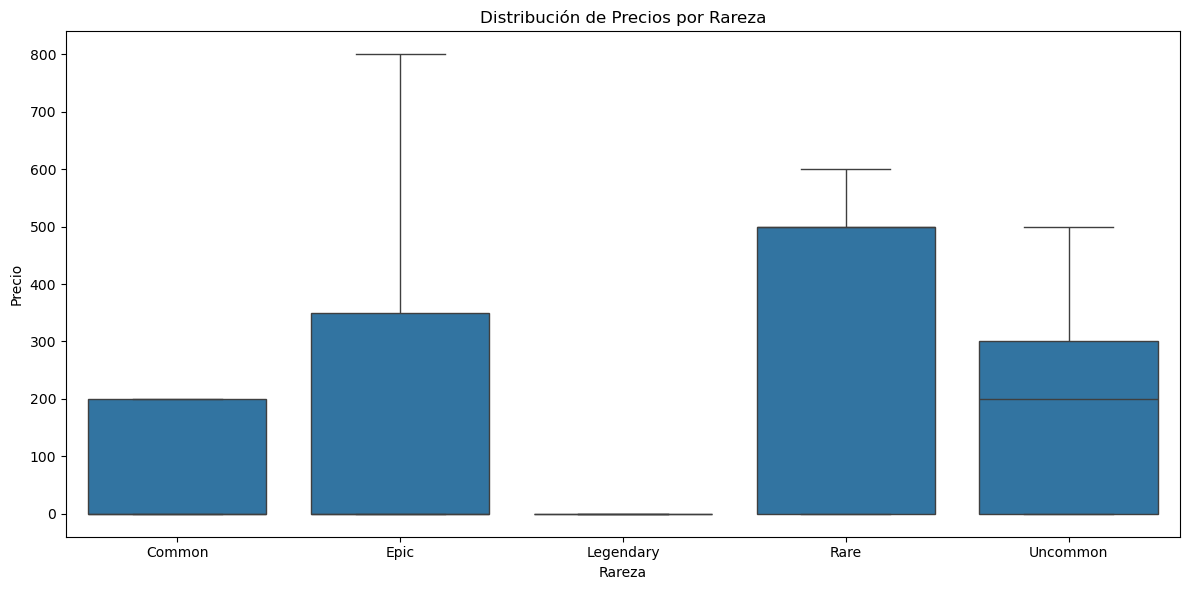

In [361]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_emotes_clean, x='rarity_id', y='price')
plt.title('Distribución de Precios por Rareza')
plt.xlabel('Rareza')
plt.ylabel('Precio')
plt.tight_layout()
plt.show()

In [362]:
# Precio promedio por rareza
print("\nPrecio promedio por rareza:")
print(df_emotes_clean.groupby('rarity_id')['price'].mean().sort_values(ascending=False))



Precio promedio por rareza:
rarity_id
Rare         329.069767
Epic         213.744076
Uncommon     193.297587
Common        84.210526
Legendary      0.000000
Name: price, dtype: float64


/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_17152/4060154468.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df_emotes_clean.groupby('rarity_id')['price'].mean().sort_values(ascending=False))


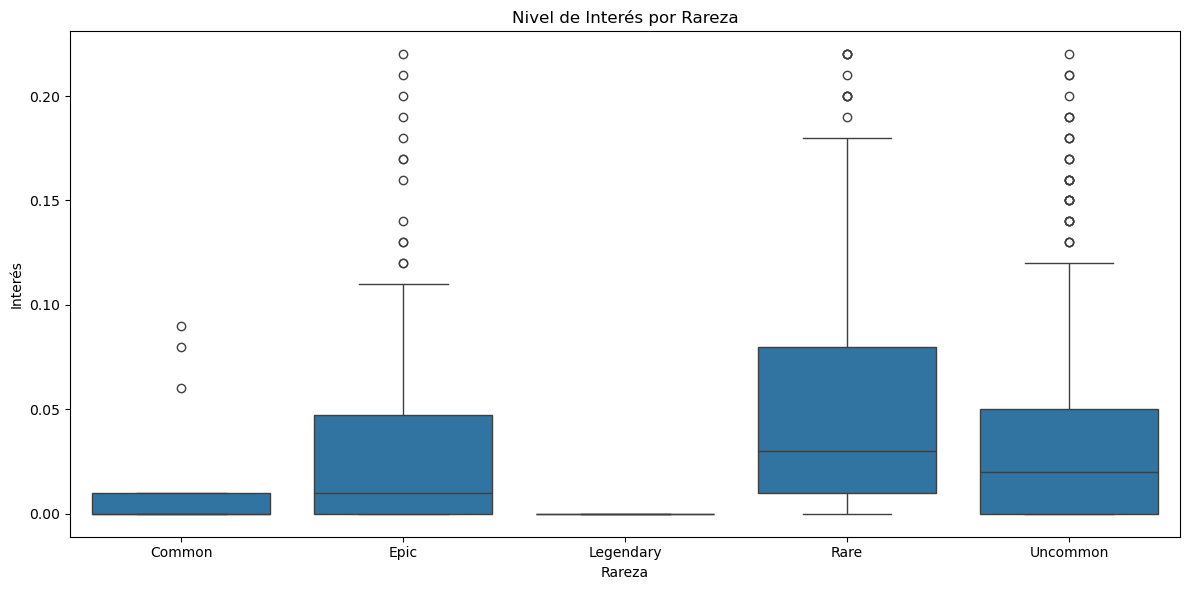

In [363]:
# 3. Nivel de interés por rareza (usando df_stats_clean para evitar outliers)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_stats_clean, x='rarity_id', y='interest')
plt.title('Nivel de Interés por Rareza')
plt.xlabel('Rareza')
plt.ylabel('Interés')
plt.tight_layout()
plt.show()

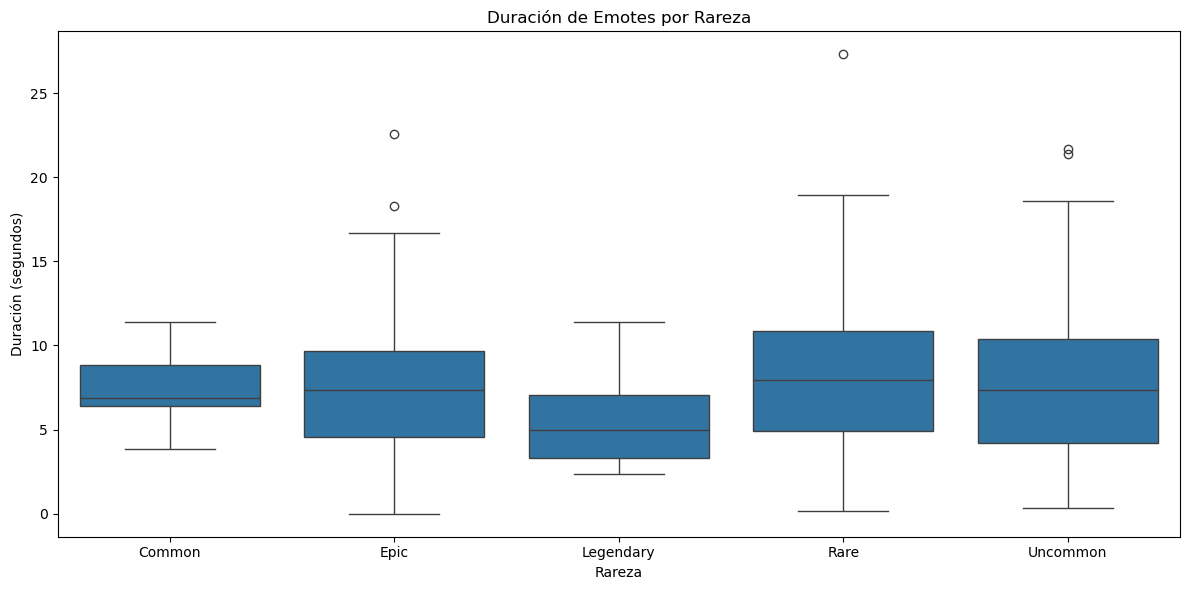

In [364]:
# 4. Duración de emotes por rareza
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_emotes_clean, x='rarity_id', y='duration')
plt.title('Duración de Emotes por Rareza')
plt.xlabel('Rareza')
plt.ylabel('Duración (segundos)')
plt.tight_layout()
plt.show()

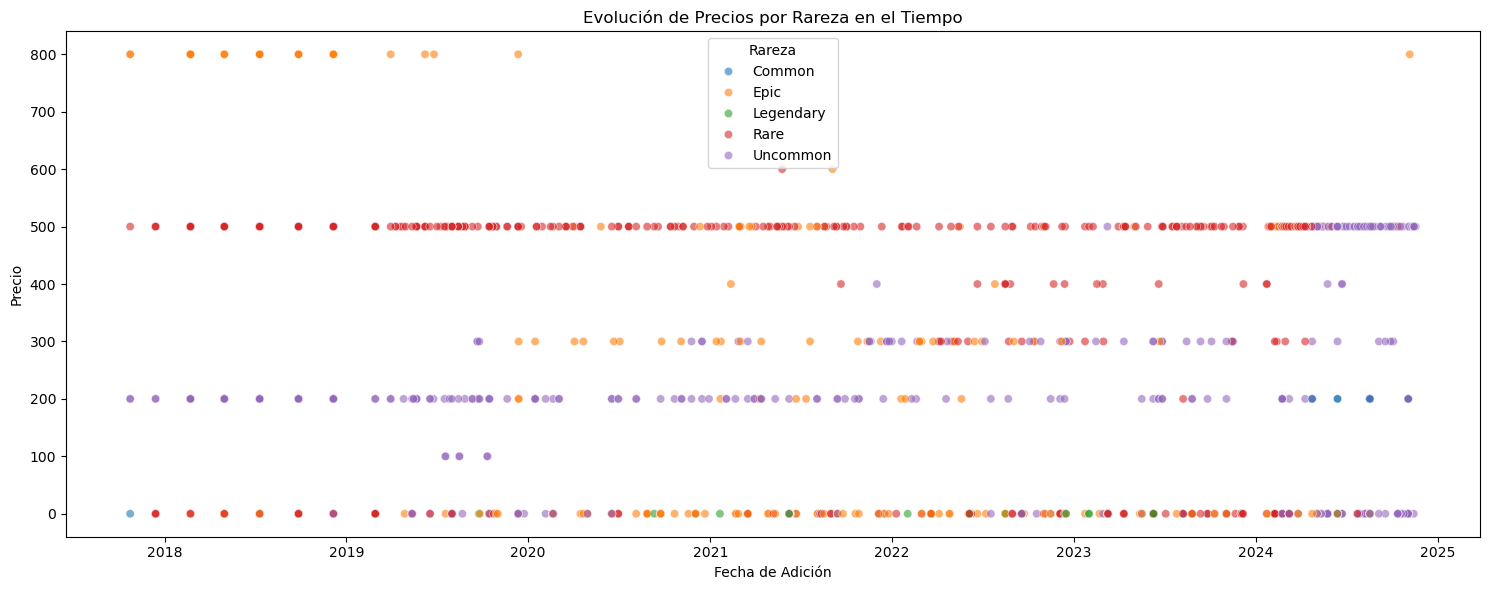

In [365]:
# 5. Evolución temporal de precios por rareza
plt.figure(figsize=(15, 6))
sns.scatterplot(data=df_emotes_clean, x='added_date', y='price', hue='rarity_id', alpha=0.6)
plt.title('Evolución de Precios por Rareza en el Tiempo')
plt.xlabel('Fecha de Adición')
plt.ylabel('Precio')
plt.legend(title='Rareza')
plt.tight_layout()
plt.show()

In [366]:
# 6. Estadísticas  por rareza
rareza_stats = df_emotes_clean.groupby('rarity_id').agg({
    'price': ['mean', 'std', 'count'],
    'interest': ['mean', 'max'],
    'duration': ['mean', 'std']
}).round(2)

print("\nEstadísticas por Rareza:")
print(rareza_stats)


Estadísticas por Rareza:
            price               interest       duration      
             mean     std count     mean   max     mean   std
rarity_id                                                    
Common      84.21  101.45    19     0.18  3.10     7.52  2.04
Epic       213.74  292.69   211     0.12  6.41     7.41  3.63
Legendary    0.00    0.00    22     0.00  0.00     5.77  2.74
Rare       329.07  228.33   430     0.15  5.56     8.00  3.90
Uncommon   193.30  169.86   373     0.11  4.06     7.70  4.02


/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_17152/1860179574.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rareza_stats = df_emotes_clean.groupby('rarity_id').agg({


<Figure size 1200x600 with 0 Axes>

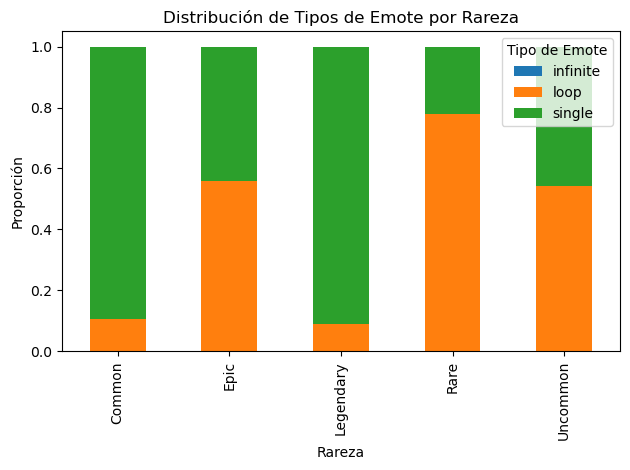

In [367]:
# 7. Distribución de tipos de emote por rareza
plt.figure(figsize=(12, 6))
emote_type_rarity = pd.crosstab(df_emotes_clean['rarity_id'], df_emotes_clean['emote_type'], normalize='index')
emote_type_rarity.plot(kind='bar', stacked=True)
plt.title('Distribución de Tipos de Emote por Rareza')
plt.xlabel('Rareza')
plt.ylabel('Proporción')
plt.legend(title='Tipo de Emote')
plt.tight_layout()
plt.show()

/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_17152/3594925731.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df_emotes_clean, x='price', hue='rarity_id', fill=True, alpha=0.5)


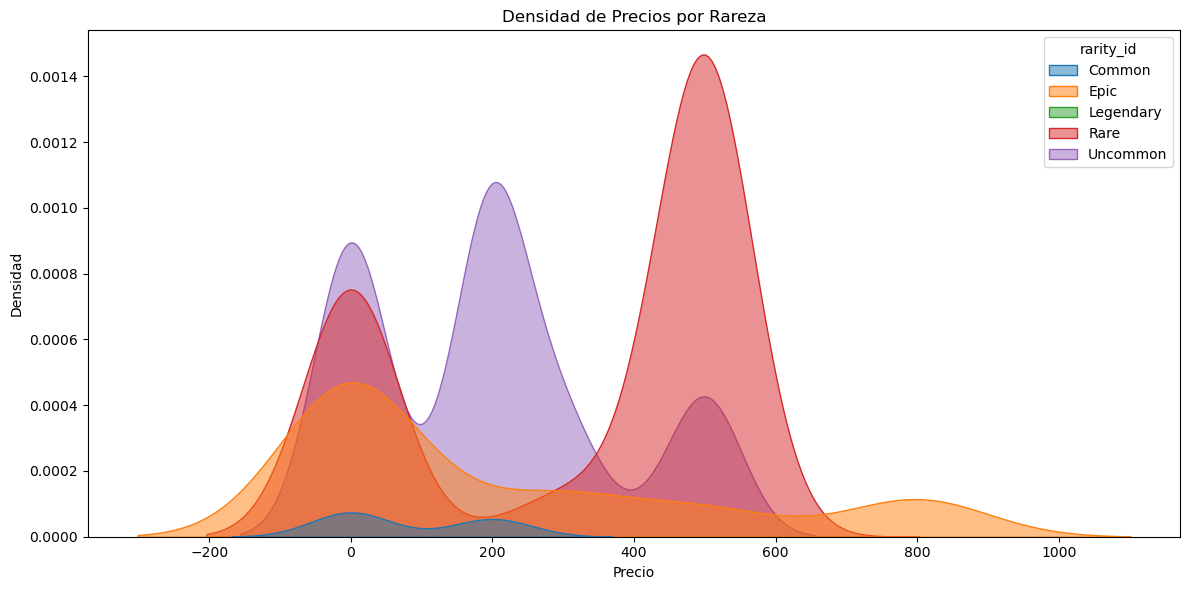

In [368]:
# 8. Densidad de precios por rareza
plt.figure(figsize=(12, 6))
sns.kdeplot(data=df_emotes_clean, x='price', hue='rarity_id', fill=True, alpha=0.5)
plt.title('Densidad de Precios por Rareza')
plt.xlabel('Precio')
plt.ylabel('Densidad')
plt.tight_layout()
plt.show()

In [369]:
# 9. ANOVA para precios entre diferentes rarezas
rareza_groups = [group['price'].values for name, group in df_emotes_clean.groupby('rarity_id')]
f_stat, p_value = stats.f_oneway(*rareza_groups)

print("\nANOVA para precios según rareza:")
print(f"Estadístico F: {f_stat:.4f}")
print(f"Valor p: {p_value:.4f}")


ANOVA para precios según rareza:
Estadístico F: 30.9773
Valor p: 0.0000


/var/folders/0j/c164mtv91wq70n6m8ptmtmww0000gn/T/ipykernel_17152/1570581939.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rareza_groups = [group['price'].values for name, group in df_emotes_clean.groupby('rarity_id')]


In [370]:
"""
F-statistic alto (30.9773) indica diferencias muy fuertes entre grupos de rareza
El p-valor extremadamente bajo (p < 0.0001) confirma que estas diferencias son altamente significativas
Esto significa que la rareza es un factor determinante en el precio de los emotes

Por lo que:
Hay una clara diferenciación de precios basada en la rareza
No es una coincidencia, sino una estrategia de precios deliberada
Epic Games usa la rareza como un factor clave en su estrategia de precios
"""

'\nF-statistic alto (30.9773) indica diferencias muy fuertes entre grupos de rareza\nEl p-valor extremadamente bajo (p < 0.0001) confirma que estas diferencias son altamente significativas\nEsto significa que la rareza es un factor determinante en el precio de los emotes\n\nPor lo que:\nHay una clara diferenciación de precios basada en la rareza\nNo es una coincidencia, sino una estrategia de precios deliberada\nEpic Games usa la rareza como un factor clave en su estrategia de precios\n'

#### Análisis de precios

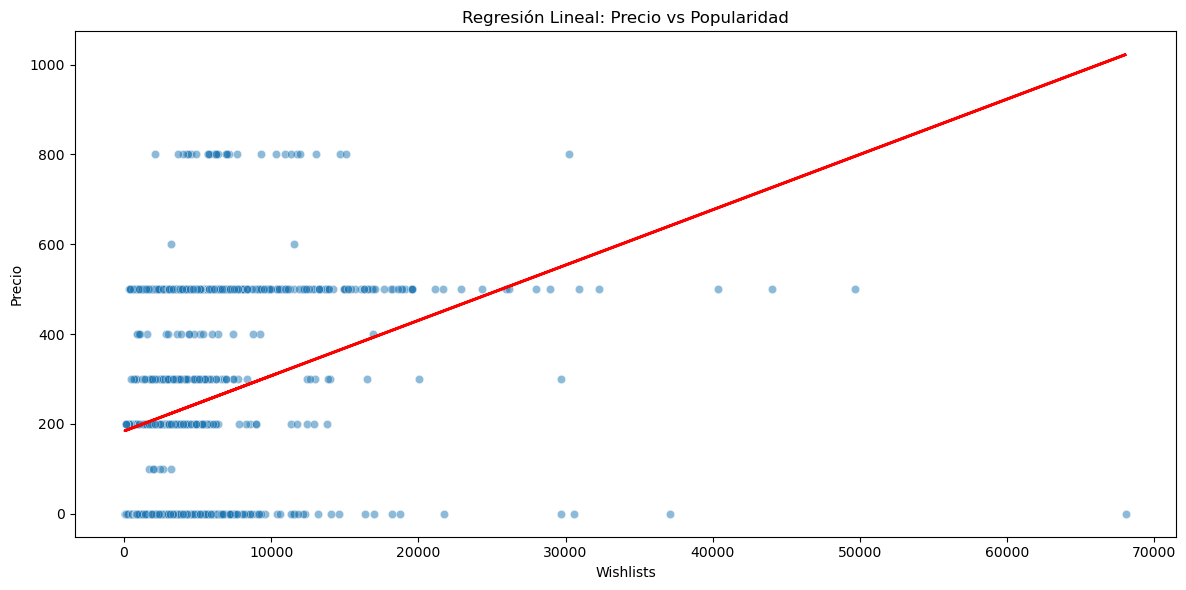

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.085
Method:                 Least Squares   F-statistic:                     99.40
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           1.96e-22
Time:                        21:44:36   Log-Likelihood:                -7200.7
No. Observations:                1055   AIC:                         1.441e+04
Df Residuals:                    1053   BIC:                         1.442e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        184.0829      9.308     19.777      0.0

In [371]:
#Para aplicar la regresion se me ocurre que se podria evaluar la lista de deseos y el precio

import statsmodels.api as sm

# Preparar datos
X = df_emotes_clean['wishlists']
X = sm.add_constant(X)  # Añadir constante para el intercepto
y = df_emotes_clean['price']

# Ajustar modelo
model = sm.OLS(y, X).fit()

# Visualización
plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_emotes_clean, x='wishlists', y='price', alpha=0.5)
plt.plot(df_emotes_clean['wishlists'], model.predict(X), color='red', linewidth=2)
plt.title('Regresión Lineal: Precio vs Popularidad')
plt.xlabel('Wishlists')
plt.ylabel('Precio')
plt.tight_layout()
plt.show()

# Mostrar resultados
print(model.summary())

In [372]:
"""
Sorpresa (creo poder interpretar esto correctamente):
R-squared: 0.086 (8.6%)
El modelo solo explica el 8.6% de la variabilidad en el precio
Sugiere que las wishlists no son un fuerte predictor del precio

F-statistic: 99.40 (p-valor = 1.96e-22)
El modelo es estadísticamente significativo
Hay una relación real entre wishlists y precio, aunque sea débil (8.6%)

Coeficientes:
Intercepto (const): 184.0829
Precio base estimado cuando no hay wishlists
Pendiente (wishlists): 0.0123
Por cada wishlist adicional, el precio aumenta en 0.0123 unidades
El efecto es muy pequeño pero significativo (p < 0.001)

Diagnósticos:
Durbin-Watson: 0.146
Indica autocorrelación positiva fuerte
Jarque-Bera: 20.961 (p = 2.81e-05)
Los residuos no siguen una distribución normal

En resumen:
Existe una relación positiva pero débil entre wishlists y precio
El modelo no es muy útil para predicción debido al bajo R-squared
"""

'\nSorpresa (creo poder interpretar esto correctamente):\nR-squared: 0.086 (8.6%)\nEl modelo solo explica el 8.6% de la variabilidad en el precio\nSugiere que las wishlists no son un fuerte predictor del precio\n\nF-statistic: 99.40 (p-valor = 1.96e-22)\nEl modelo es estadísticamente significativo\nHay una relación real entre wishlists y precio, aunque sea débil (8.6%)\n\nCoeficientes:\nIntercepto (const): 184.0829\nPrecio base estimado cuando no hay wishlists\nPendiente (wishlists): 0.0123\nPor cada wishlist adicional, el precio aumenta en 0.0123 unidades\nEl efecto es muy pequeño pero significativo (p < 0.001)\n\nDiagnósticos:\nDurbin-Watson: 0.146\nIndica autocorrelación positiva fuerte\nJarque-Bera: 20.961 (p = 2.81e-05)\nLos residuos no siguen una distribución normal\n\nEn resumen:\nExiste una relación positiva pero débil entre wishlists y precio\nEl modelo no es muy útil para predicción debido al bajo R-squared\n'

#### Análisis de sets

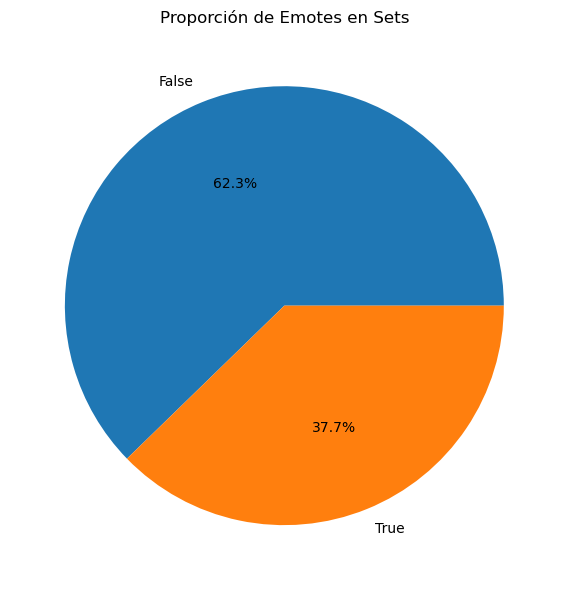

In [373]:
# Crear una columna binaria para identificar si pertenece a un set
df_emotes_clean['tiene_set'] = df_emotes_clean['set_partOf'].notna()

# 1. Proporción de emotes en sets
plt.figure(figsize=(10, 6))
df_emotes_clean['tiene_set'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%')
plt.title('Proporción de Emotes en Sets')
plt.ylabel('')
plt.tight_layout()
plt.show()

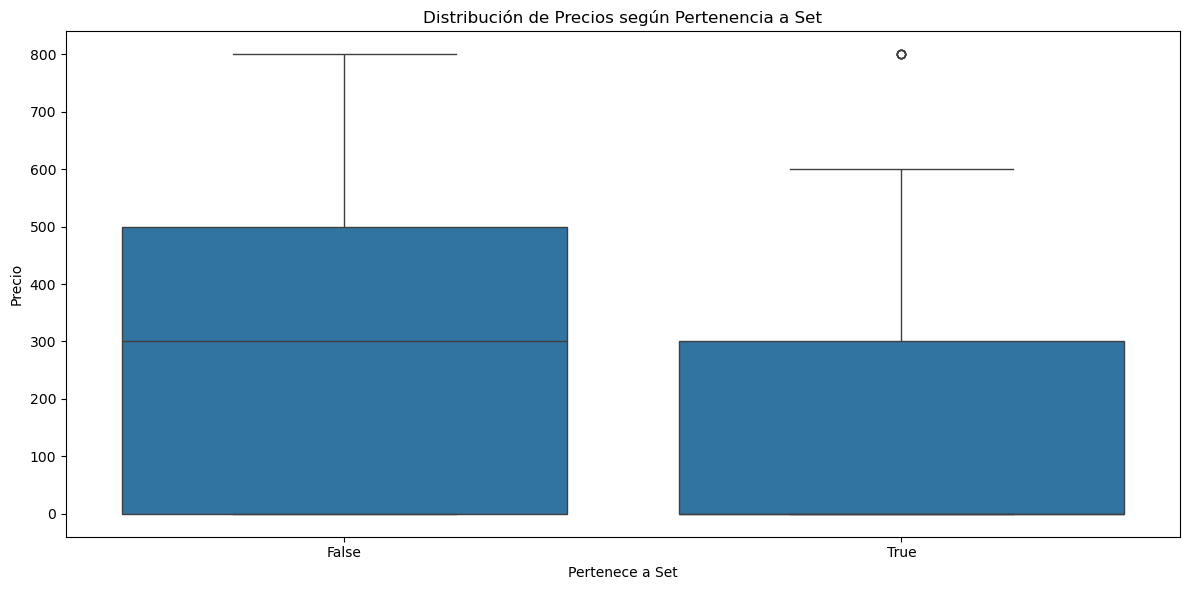

In [374]:
# 2. Comparación de precios
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_emotes_clean, x='tiene_set', y='price')
plt.title('Distribución de Precios según Pertenencia a Set')
plt.xlabel('Pertenece a Set')
plt.ylabel('Precio')
plt.tight_layout()
plt.show()

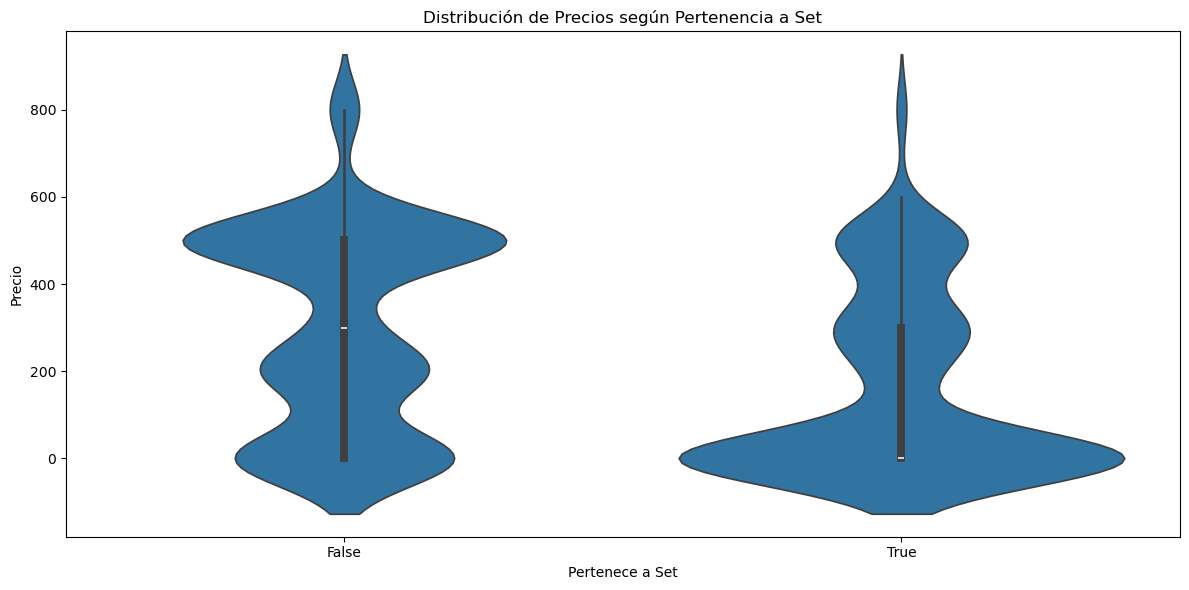

In [375]:
# Versión con violinplot para ver la distribución completa
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_emotes_clean, x='tiene_set', y='price')
plt.title('Distribución de Precios según Pertenencia a Set')
plt.xlabel('Pertenece a Set')
plt.ylabel('Precio')
plt.tight_layout()
plt.show()

In [376]:
# 4. Estadísticas 
print("\nEstadísticas de precios por grupo:")
print(df_emotes_clean.groupby('tiene_set')['price'].describe())

# Calcular el tamaño del efecto (Cohen's d)
def cohens_d(group1, group2):
    n1, n2 = len(group1), len(group2)
    var1, var2 = group1.var(), group2.var()
    pooled_se = np.sqrt(((n1 - 1) * var1 + (n2 - 1) * var2) / (n1 + n2 - 2))
    return (group1.mean() - group2.mean()) / pooled_se

effect_size = cohens_d(
    df_emotes_clean[df_emotes_clean['tiene_set']]['price'],
    df_emotes_clean[~df_emotes_clean['tiene_set']]['price']
)

print(f"\nTamaño del efecto (Cohen's d): {effect_size:.4f}")

# Calcular el precio promedio para cada grupo
precio_promedio = df_emotes_clean.groupby('tiene_set')['price'].mean()
print("\nPrecio promedio de emotes:")
print("Con set:", precio_promedio[True])
print("Sin set:", precio_promedio[False])


Estadísticas de precios por grupo:
           count        mean         std  min  25%    50%    75%    max
tiene_set                                                              
False      657.0  298.021309  231.930616  0.0  0.0  300.0  500.0  800.0
True       398.0  162.060302  209.696377  0.0  0.0    0.0  300.0  800.0

Tamaño del efecto (Cohen's d): -0.6075

Precio promedio de emotes:
Con set: 162.0603015075377
Sin set: 298.02130898021306


In [377]:
"""
Los emotes sin set son significativamente más caros (diferencia de ~136 V-Bucks)
Mayor variabilidad en precios para emotes sin set
Alta proporción de emotes gratuitos en sets (mediana 0)

En conclusión:
Los emotes que forman parte de sets tienden a ser más baratos
La diferencia en precios es tanto estadística como prácticamente significativa
Hay una mayor proporción de emotes gratuitos en sets ... podría ser los pases de batalla que son un caso aparte (tenía pendiente preguntar al experto -mi hijo- pero no pude validarlo aún )
"""

'\nLos emotes sin set son significativamente más caros (diferencia de ~136 V-Bucks)\nMayor variabilidad en precios para emotes sin set\nAlta proporción de emotes gratuitos en sets (mediana 0)\n\nEn conclusión:\nLos emotes que forman parte de sets tienden a ser más baratos\nLa diferencia en precios es tanto estadística como prácticamente significativa\nHay una mayor proporción de emotes gratuitos en sets ... podría ser los pases de batalla que son un caso aparte (tenía pendiente preguntar al experto -mi hijo- pero no pude validarlo aún )\n'

#### Análisis de Estacionalidad

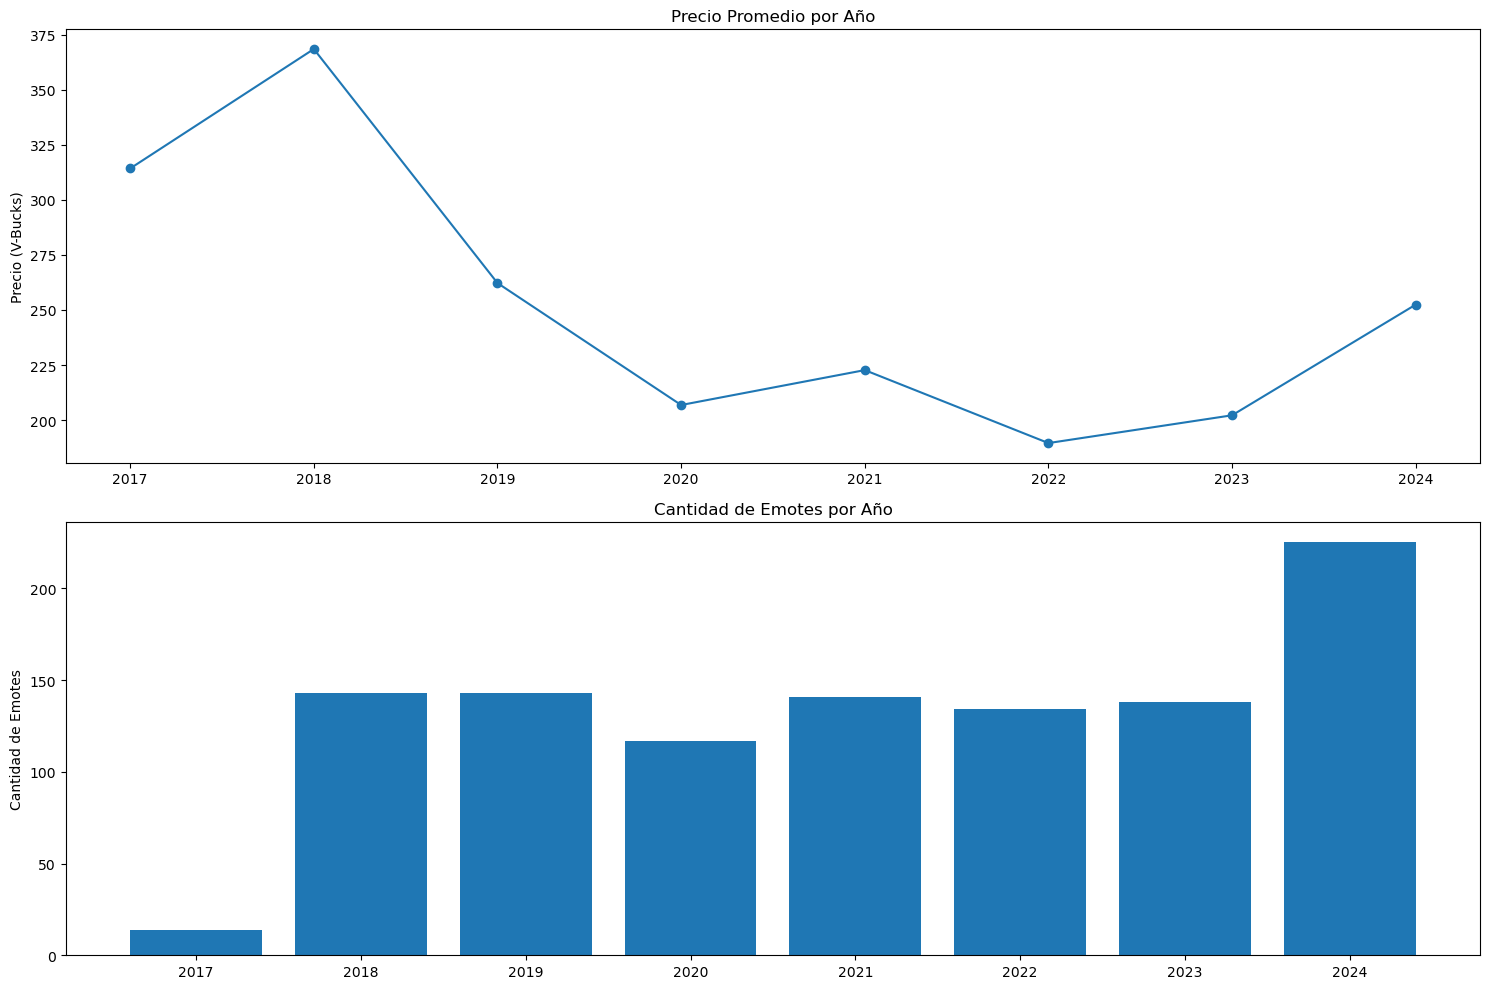

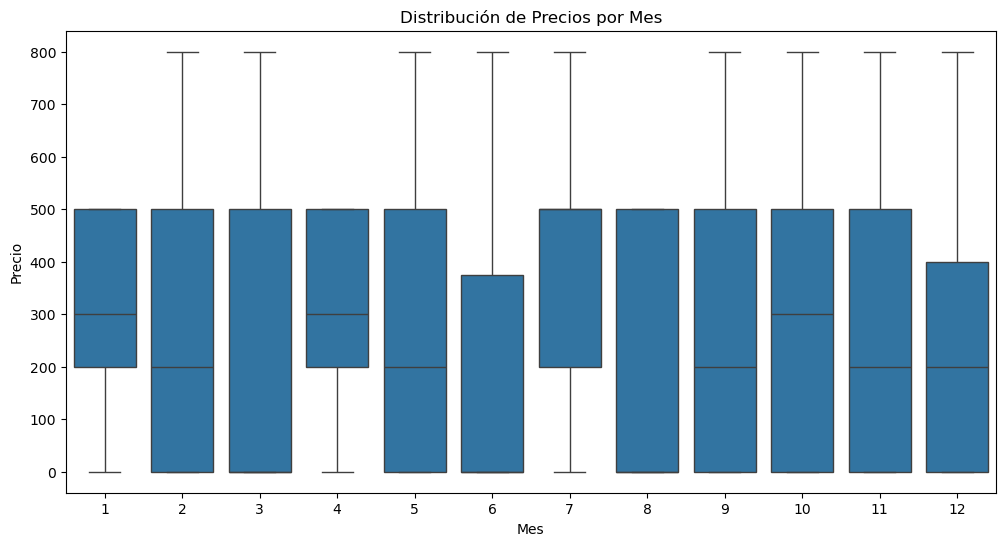

KeyError: 'Column not found: community_ratio'

<Figure size 1200x600 with 0 Axes>

In [378]:
# 1. Evolución anual de precios y lanzamientos
plt.figure(figsize=(15, 10))

# Precios promedio por año
plt.subplot(2, 1, 1)
yearly_prices = df_emotes_clean.groupby('año')['price'].mean()
plt.plot(yearly_prices.index, yearly_prices.values, marker='o')
plt.title('Precio Promedio por Año')
plt.ylabel('Precio (V-Bucks)')

# Cantidad de emotes por año
plt.subplot(2, 1, 2)
yearly_counts = df_emotes_clean['año'].value_counts().sort_index()
plt.bar(yearly_counts.index, yearly_counts.values)
plt.title('Cantidad de Emotes por Año')
plt.ylabel('Cantidad de Emotes')
plt.tight_layout()
plt.show()

# 2. Análisis estacional (por mes)
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_emotes_clean, x='mes', y='price')
plt.title('Distribución de Precios por Mes')
plt.xlabel('Mes')
plt.ylabel('Precio')
plt.show()

# 3. Evolución de la valoración de la comunidad por año
plt.figure(figsize=(12, 6))
yearly_ratio = df_emotes_clean.groupby('año')['community_ratio'].mean()
plt.plot(yearly_ratio.index, yearly_ratio.values, marker='o')
plt.title('Evolución del Ratio de la Comunidad por Año')
plt.xlabel('Año')
plt.ylabel('Ratio Comunidad')
plt.grid(True)
plt.show()

# 4. Test estadístico para diferencias estacionales
from scipy import stats

# ANOVA para precios por mes
monthly_groups = [group['price'].values for name, group in df_emotes_clean.groupby('mes')]
f_stat, p_value = stats.f_oneway(*monthly_groups)

print("\nANOVA para diferencias estacionales en precios:")
print(f"F-statistic: {f_stat:.4f}")
print(f"p-value: {p_value:.4f}")

# 5. Estadísticas descriptivas por año
yearly_stats = df_emotes_clean.groupby('año').agg({
    'price': ['mean', 'std', 'count'],
    'community_ratio': 'mean',
    'wishlists': 'mean'
}).round(2)

print("\nEstadísticas por año:")
print(yearly_stats)

In [ ]:
# Conclusión: Hay diferencias significativas en los precios según el mes
# Esto sugiere una clara estacionalidad en la estrategia de precios

# Evolución Temporal (2017-2024):
#   Precios:
#       Tendencia general: Decreciente
#       Pico: 2018 (368.53 V-Bucks)
#       Valle: 2022 (189.55 V-Bucks)
#       Recuperación reciente: 2024 (252.44 V-Bucks)


#Valoración de la Comunidad (community_ratio):
#       Tendencia: Decreciente
#       Mejor año: 2017 (5.98)
#       Peor año: 2024 (2.91)
#       Sugiere una posible "fatiga" de la comunidad

#Wishlists:
#       Tendencia: Fuertemente decreciente
#       Consistente con la anterior

#Observaciones Clave:
#1. Volumen de Lanzamientos:
#       Aumento significativo en 2024 (225 emotes)
#       Promedio anterior: ~140 emotes/año
#2. Estrategia de Precios:
#       Reducción de precios desde 2018
#       Posible estrategia para mantener competitividad

#Quizas el aumento en volumen de lanzamientos podría estar afectando la percepción de valor

In [347]:
# Predicción de precios basada en el tiempo
X = df_emotes_clean[['año', 'mes']]
X = sm.add_constant(X)
y = df_emotes_clean['price']

model = sm.OLS(y, X).fit()
print("\nRegresión Temporal de Precios:")
print(model.summary())


Regresión Temporal de Precios:
                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.021
Method:                 Least Squares   F-statistic:                     12.18
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           5.88e-06
Time:                        15:00:01   Log-Likelihood:                -7236.2
No. Observations:                1055   AIC:                         1.448e+04
Df Residuals:                    1052   BIC:                         1.449e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.186e+0


Tamaño del dataset después de limpiar: 1055

Regresión para Ocurrencias:
                            OLS Regression Results                            
Dep. Variable:            occurrences   R-squared:                       0.192
Model:                            OLS   Adj. R-squared:                  0.190
Method:                 Least Squares   F-statistic:                     124.7
Date:                Thu, 21 Nov 2024   Prob (F-statistic):           2.55e-49
Time:                        15:03:22   Log-Likelihood:                -4739.0
No. Observations:                1055   AIC:                             9484.
Df Residuals:                    1052   BIC:                             9499.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------

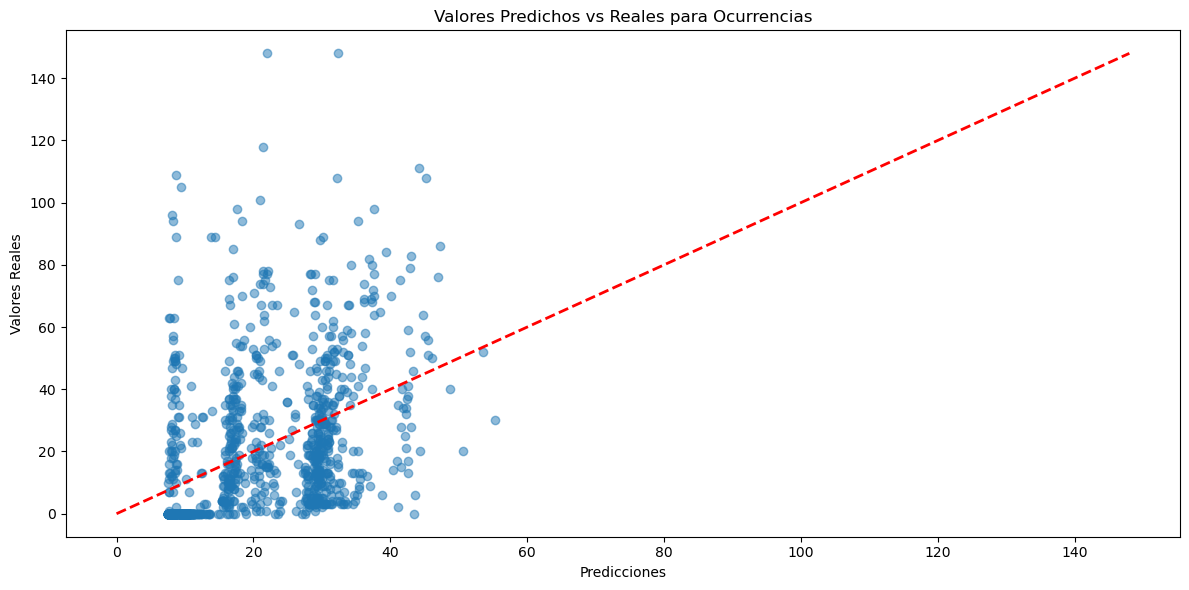

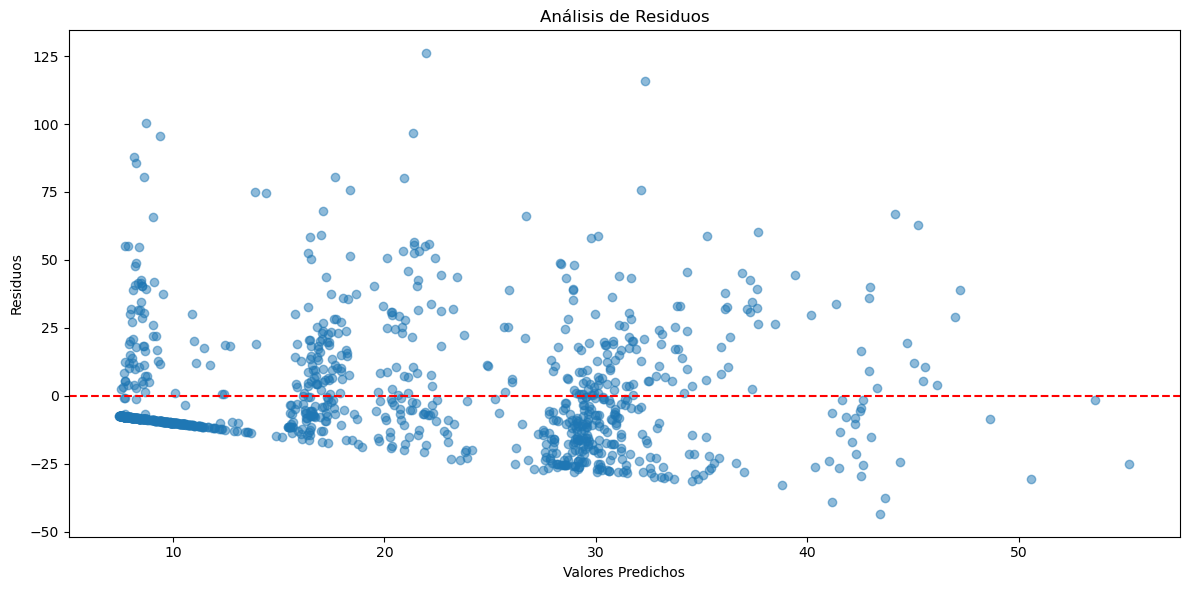

In [407]:
# 2. Crear un DataFrame limpio solo con las variables que necesitamos
df_regression = df_emotes_clean[['price', 'wishlists', 'occurrences']].copy()

# 3. Eliminar filas con valores faltantes
df_regression = df_regression.dropna()

print("\nTamaño del dataset después de limpiar:", len(df_regression))

# 4. Hacer la regresión
X = df_regression[['price', 'wishlists']]
X = sm.add_constant(X)
y = df_regression['occurrences']

# Ajustar modelo
model = sm.OLS(y, X).fit()
print("\nRegresión para Ocurrencias:")
print(model.summary())

# Visualización
plt.figure(figsize=(12, 6))
plt.scatter(model.fittedvalues, y, alpha=0.5)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.title('Valores Predichos vs Reales para Ocurrencias')
plt.tight_layout()
plt.show()

# Análisis de residuos
residuals = model.resid
plt.figure(figsize=(12, 6))
plt.scatter(model.fittedvalues, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Valores Predichos')
plt.ylabel('Residuos')
plt.title('Análisis de Residuos')
plt.tight_layout()
plt.show()

In [ ]:
"""

El modelo explica el 19.2% de la variabilidad en las ocurrencias
El modelo es altamente significativo F-statistic: 124.7 (p-valor = 2.55e-49)
Por cada V-Buck adicional, las ocurrencias aumentan en 0.0398
Más wishlists = ligeramente más ocurrencias

Concluyo que:
Los emotes más caros tienden a aparecer más en la tienda
La popularidad (wishlists) tiene un efecto menor
se podria iterar con mas variables para predecir mejor...
"""